## Naive and Seasonal Naive models
Code use for creation of naive models.
Those models predict for a window of 1,2,3 and 4 weeks ahead.
The first one use a rolling prediction using 1 week then move and predict. 
For the 2 weeks prediction use the last week value then moves and use the predict value to do the same and so on for the 3 and 4 week.

In [163]:
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
#!pip install pmdarima --quiet
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


In [164]:
ari = pd.read_csv("data_ari.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])
ari = ari.drop(columns=['Unnamed: 0']).reset_index(drop=True)


In [165]:
ili = pd.read_csv("data_ili.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])
ili = ili.drop(columns=['Unnamed: 0']).reset_index(drop=True)


The metrics use are MAE and RSME 

In [166]:
def eval_metrics(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan, np.nan

    mae = mean_absolute_error(y_true[mask], y_pred[mask])
    rmse = root_mean_squared_error(y_true[mask], y_pred[mask])

    return mae, rmse

Function to separete train,test. Depending on the lengh of the data the date that you should give.

In [167]:
def train_data(df,location,date):
    df = df[df['location']==location]
    df = df.set_index('truth_date')
    train = df[df.index<=date]
    test = df[df.index>date]
    return train,test

In [168]:
mape_ari = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])
mape_ili = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])

First week prediction use shift to do the predictions

For the 2-4 weeks i took a different approach. first use the prediction of 1 week and the copy this value 2 times for the 2 weeks and so on.

In [169]:
def plot_train_test(train, test, model_name, location, aux):
    plt.figure(figsize=(15, 7))

    # Plot actual data
    plt.plot(train.index, train["value"], color='blue', label='Training Data')
    plt.plot(test.index, test["value"], color='orange', label='Actual Test Data')

    # Unified forecast column names
    forecast_horizons = {
        "prediction_1_weeks": ("1 Week Ahead", "green"),
        "prediction_2_weeks": ("2 Weeks Ahead", "red"),
        "prediction_3_weeks": ("3 Weeks Ahead", "purple"),
        "prediction_4_weeks": ("4 Weeks Ahead", "brown"),
    }

    for col, (label, color) in forecast_horizons.items():
        if col in test.columns:
            plt.plot(test.index, test[col], linestyle='--', color=color, label=f'{model_name} {label}')

    plt.legend(loc='upper left')
    plt.title(f"{model_name} Forecasting – {location}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots_naive/plot_{location}_{aux}.jpg", format='jpg', dpi=300)


In [170]:
def naive_rolling_4week_multi_forecast(train, test, country, mape):
    forecast_horizon = 4
    step_size = 4

    predictions = []

    test_index = test.index
    full_series = pd.concat([train, test])['value']

    i = 0
    while i + forecast_horizon <= len(test_index):
        current_week = test_index[i]
        forecast_start = current_week
        forecast_dates = test_index[i:i+forecast_horizon]

        # Use last known value up to this forecast
        if i == 0:
            last_value = train["value"].iloc[-1]
        else:
            last_value = test.loc[test_index[i - 1], "value"]

        pred_row = {"forecast_start": forecast_start}
        for h in range(1, forecast_horizon + 1):
            pred_row[f"prediction_{h}_week"] = last_value

        predictions.append(pred_row)
        i += step_size

    # Create forecast DataFrame
    forecast_df = pd.DataFrame(predictions).set_index("forecast_start")

    # Evaluate and add to mape using your eval_metrics
    for h in range(1, forecast_horizon + 1):
        pred_col = f"prediction_{h}_week"
        pred_dates = forecast_df.index + pd.to_timedelta(h, unit="W")
        valid_dates = pred_dates.intersection(test.index)

        y_true = test.loc[valid_dates, "value"]
        y_pred = forecast_df.loc[forecast_df.index.intersection(valid_dates - pd.to_timedelta(h, unit="W")), pred_col].values

        mae, rmse = eval_metrics(y_true, y_pred)

        mape = pd.concat([
            mape,
            pd.DataFrame([[country, 'naive', f"{h}_week", mae, rmse]],
                         columns=['location', 'model', 'prediction_window', 'mae', 'rmse'])
        ], ignore_index=True)

    return forecast_df, mape


In [171]:
def plot_multi_horizon_forecasts(train, test, forecast_df, location, model_name):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 7))

    # 1. Plot training data
    plt.plot(train.index, train["value"], color='blue', label='Training Data')

    # 2. Plot actual test values
    plt.plot(test.index, test["value"], color='orange', label='Actual Test Data')

    # 3. Plot predictions for each horizon
    for h in range(1, 5):
        pred_col = f"prediction_{h}_week"
        if pred_col in forecast_df.columns:
            pred_dates = forecast_df.index + pd.to_timedelta(h, unit="W")
            plt.plot(pred_dates, forecast_df[pred_col], linestyle='--', label=f"{model_name} {h}-week ahead")

    plt.title(f"{model_name} Forecasts – {location}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [172]:
name_ari = ari["location"].unique()
name_ili = ili["location"].unique()

CZ


C:\Users\flore\AppData\Local\Temp\ipykernel_13104\931820079.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape = pd.concat([


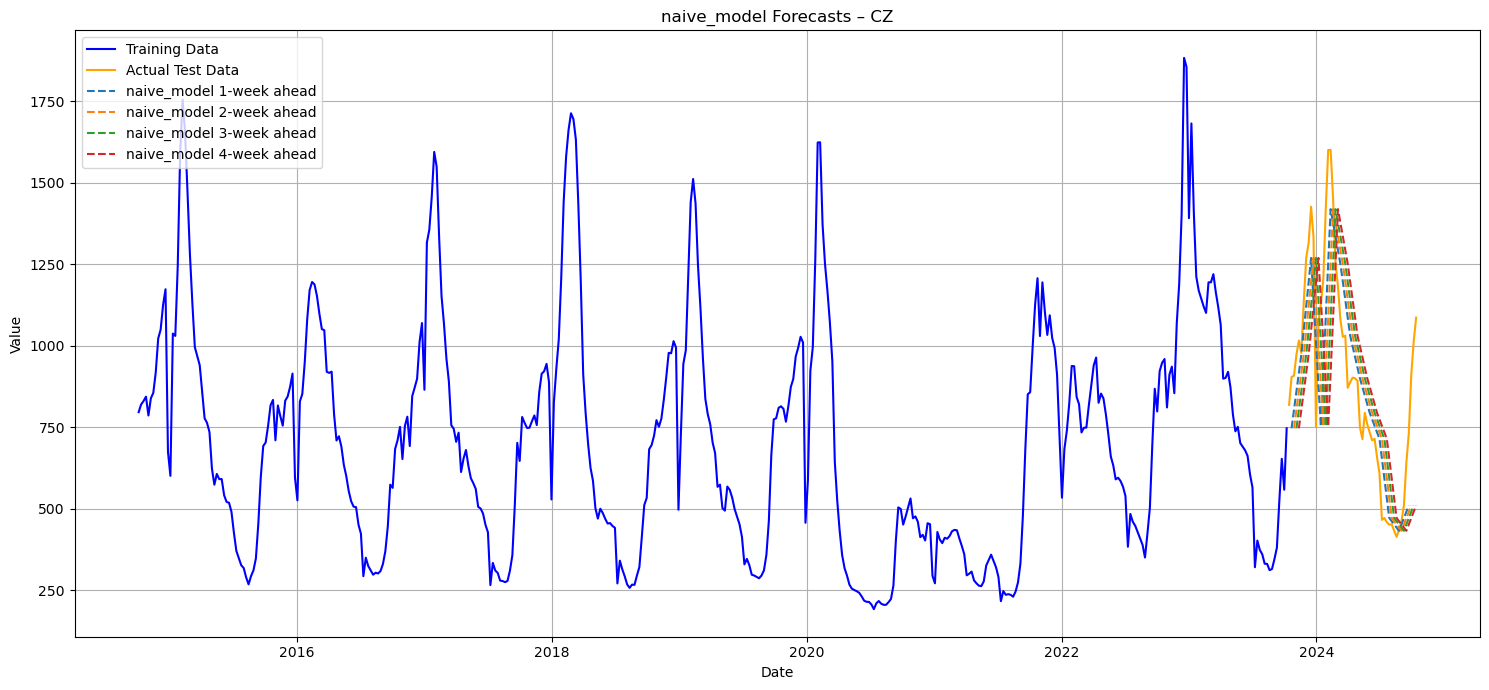

SI


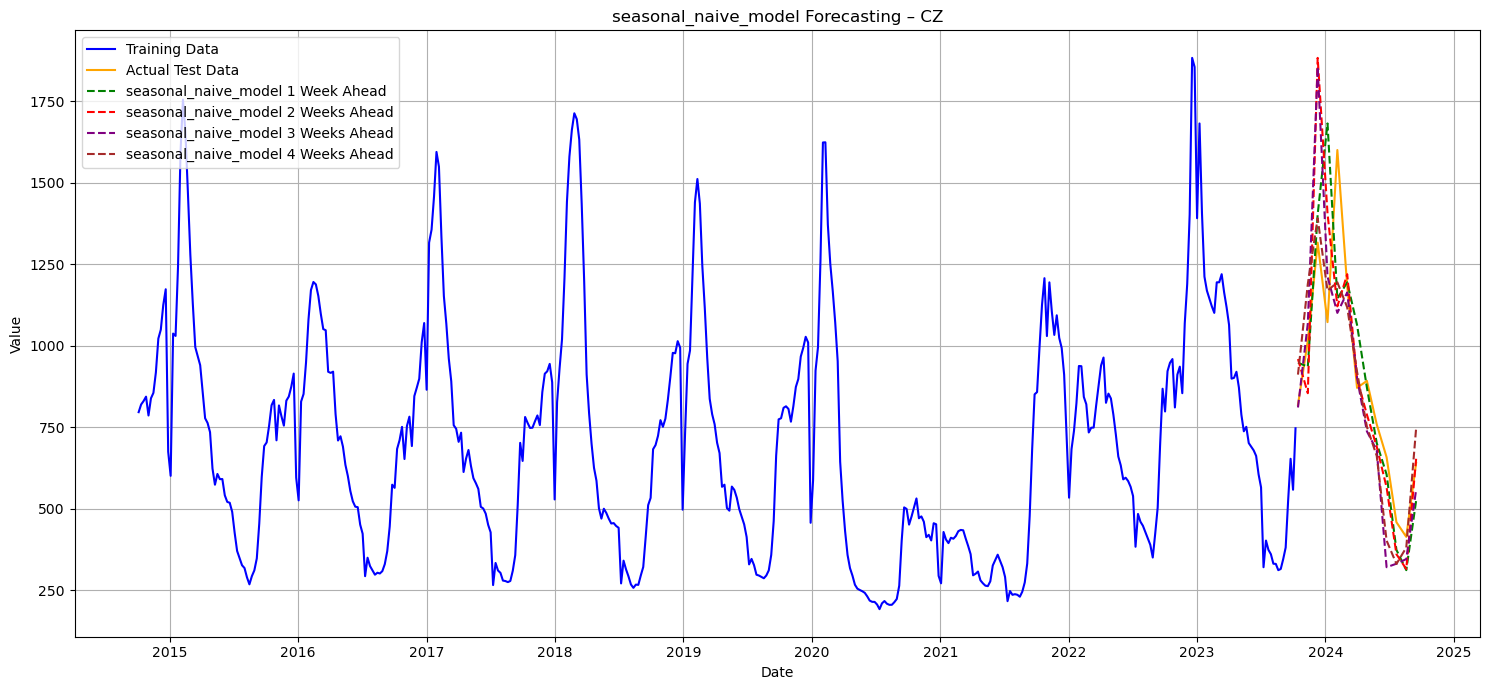

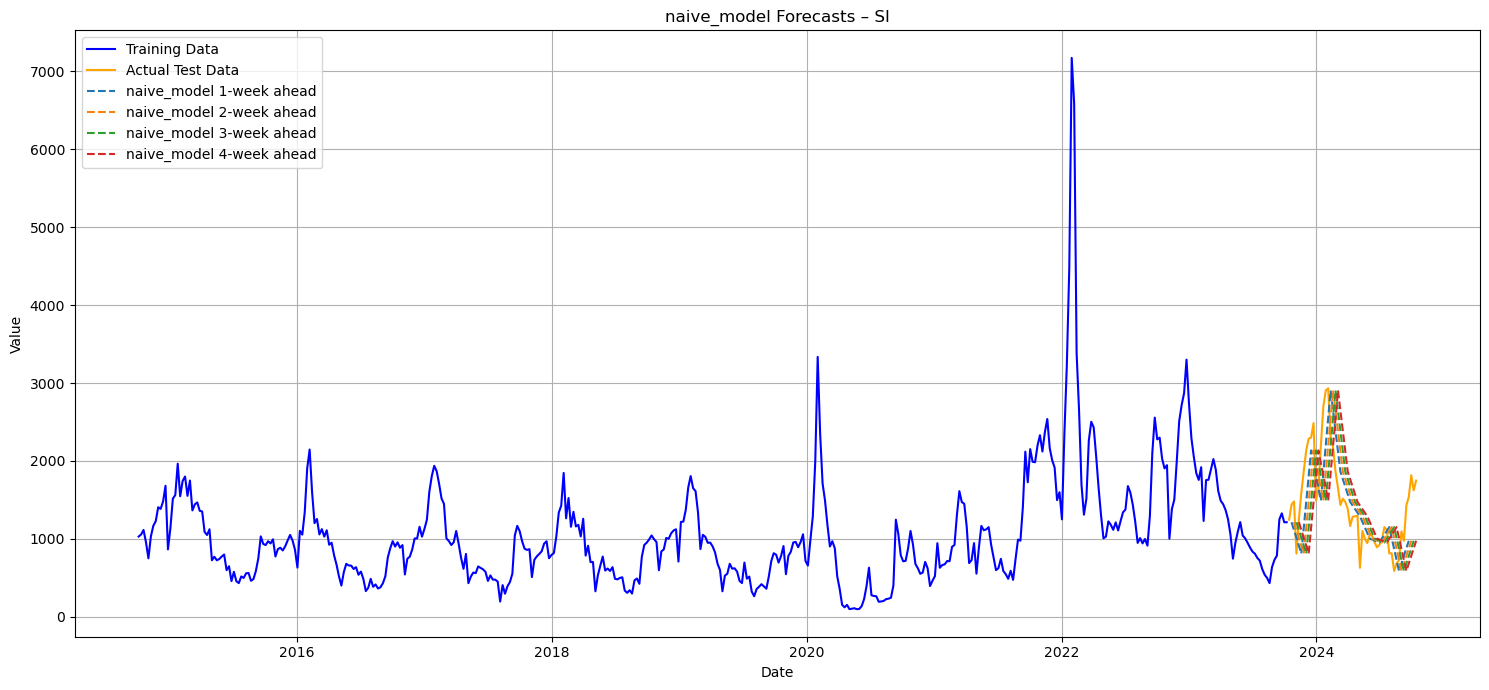

LU


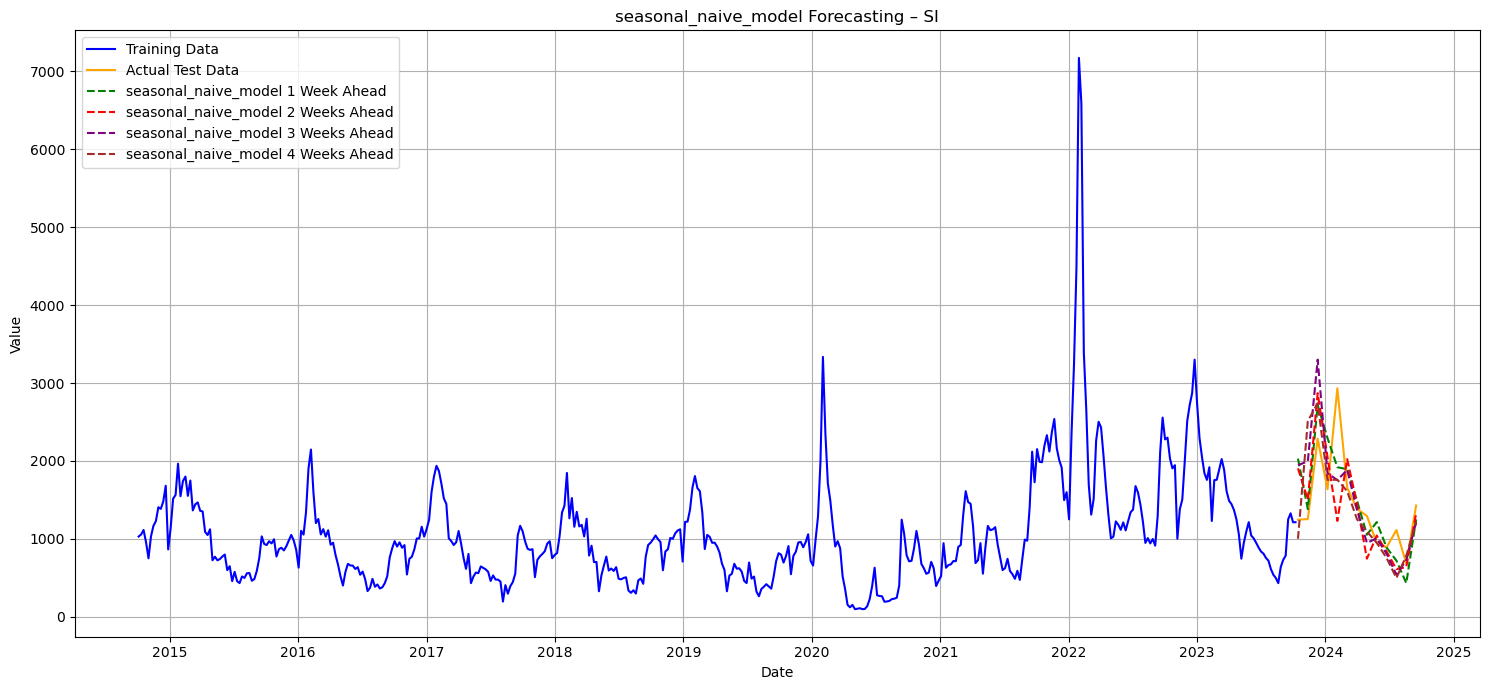

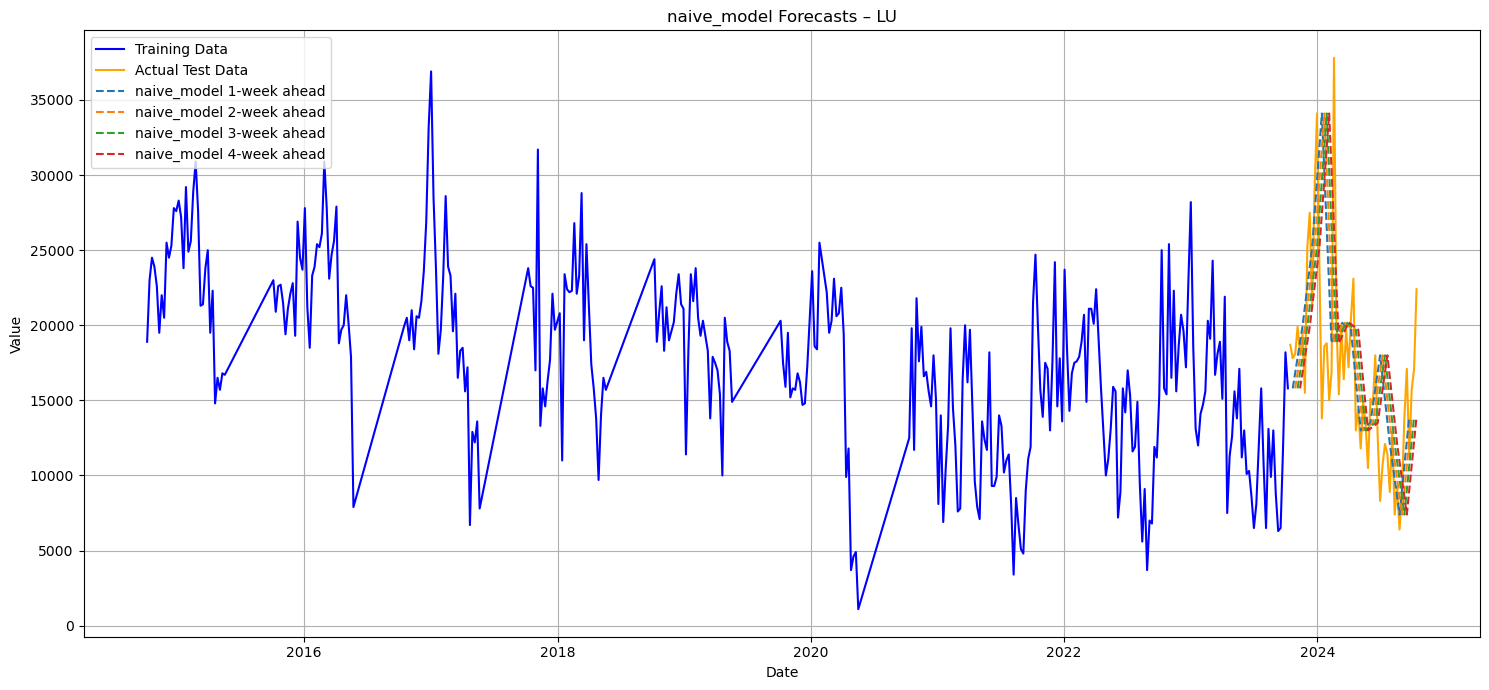

EE


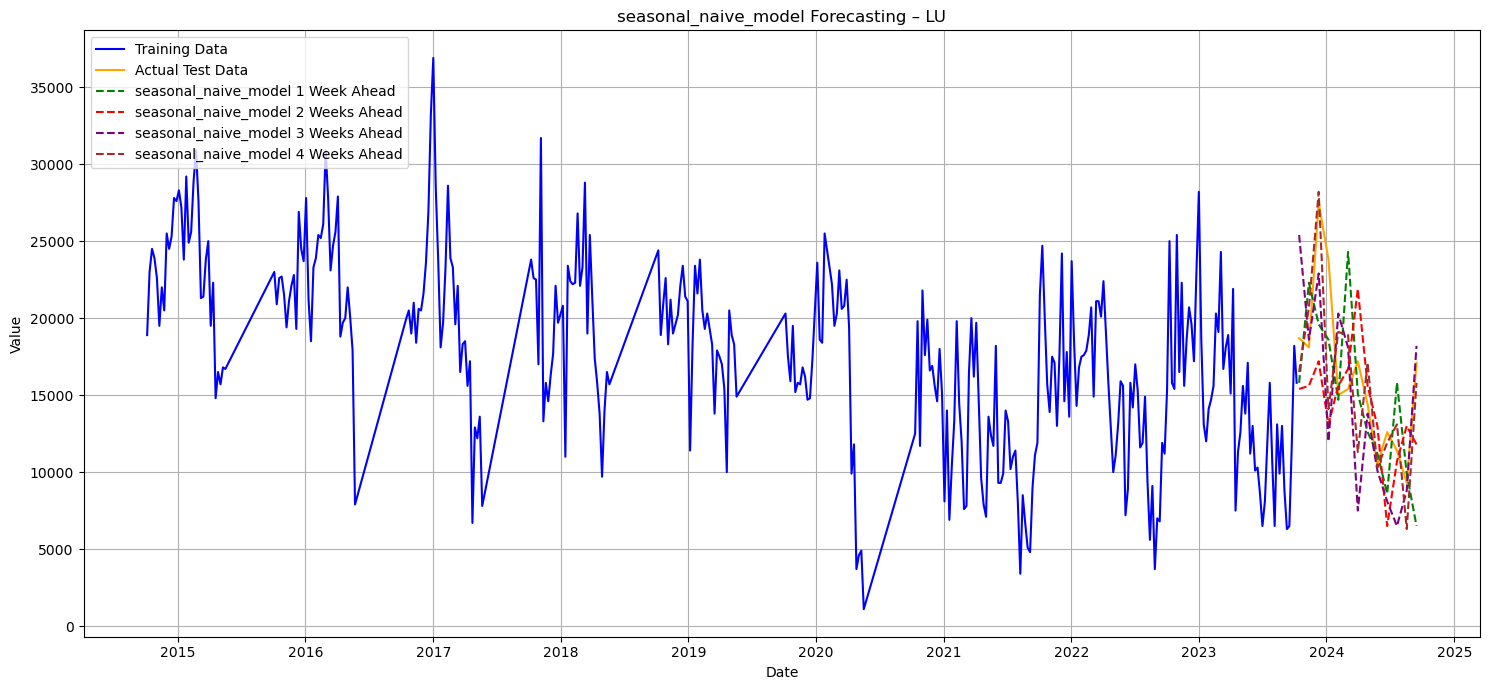

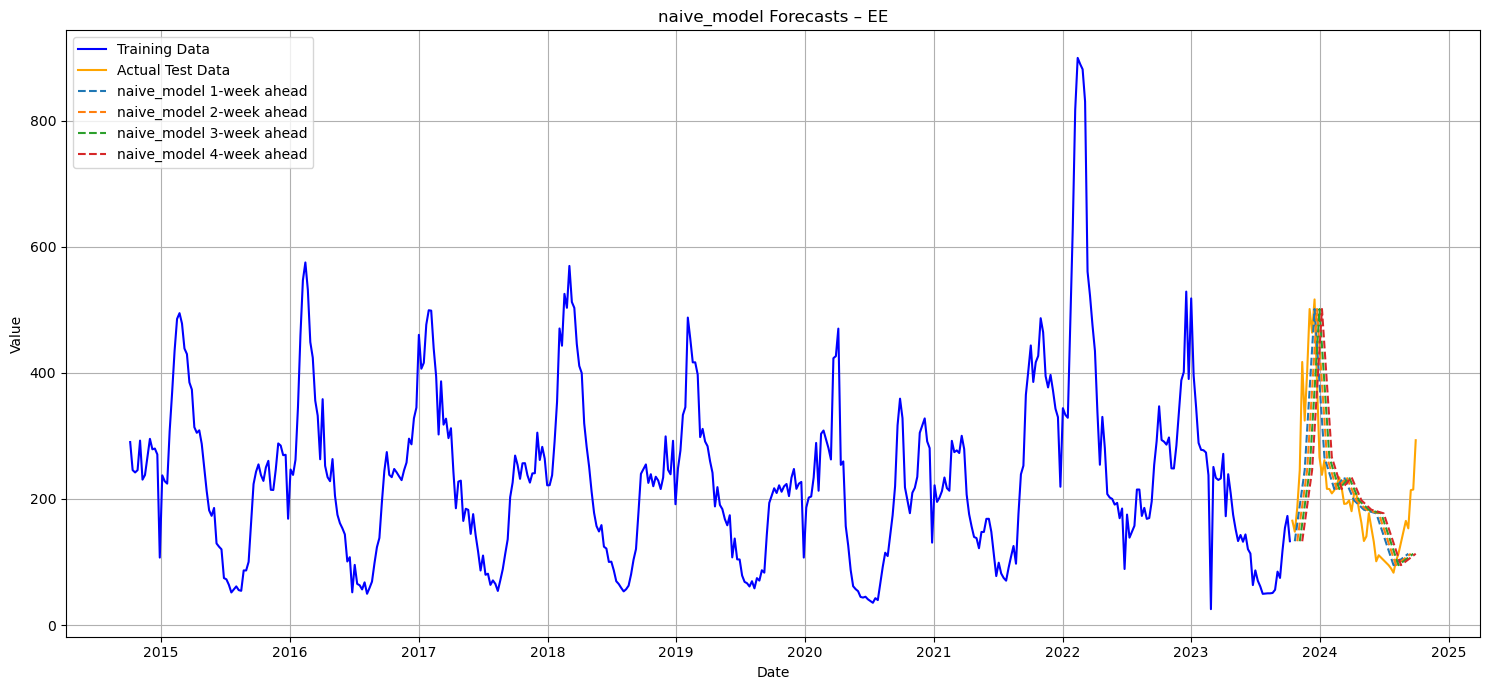

BG


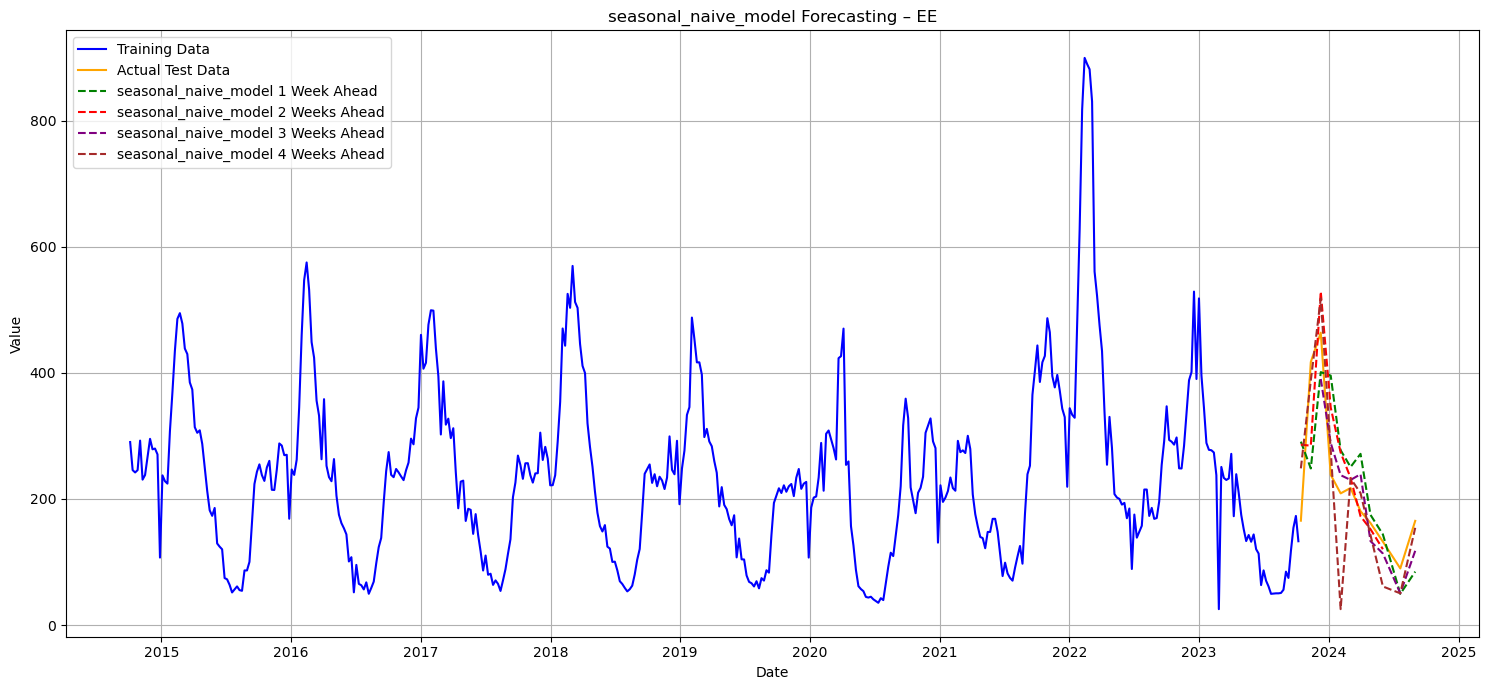

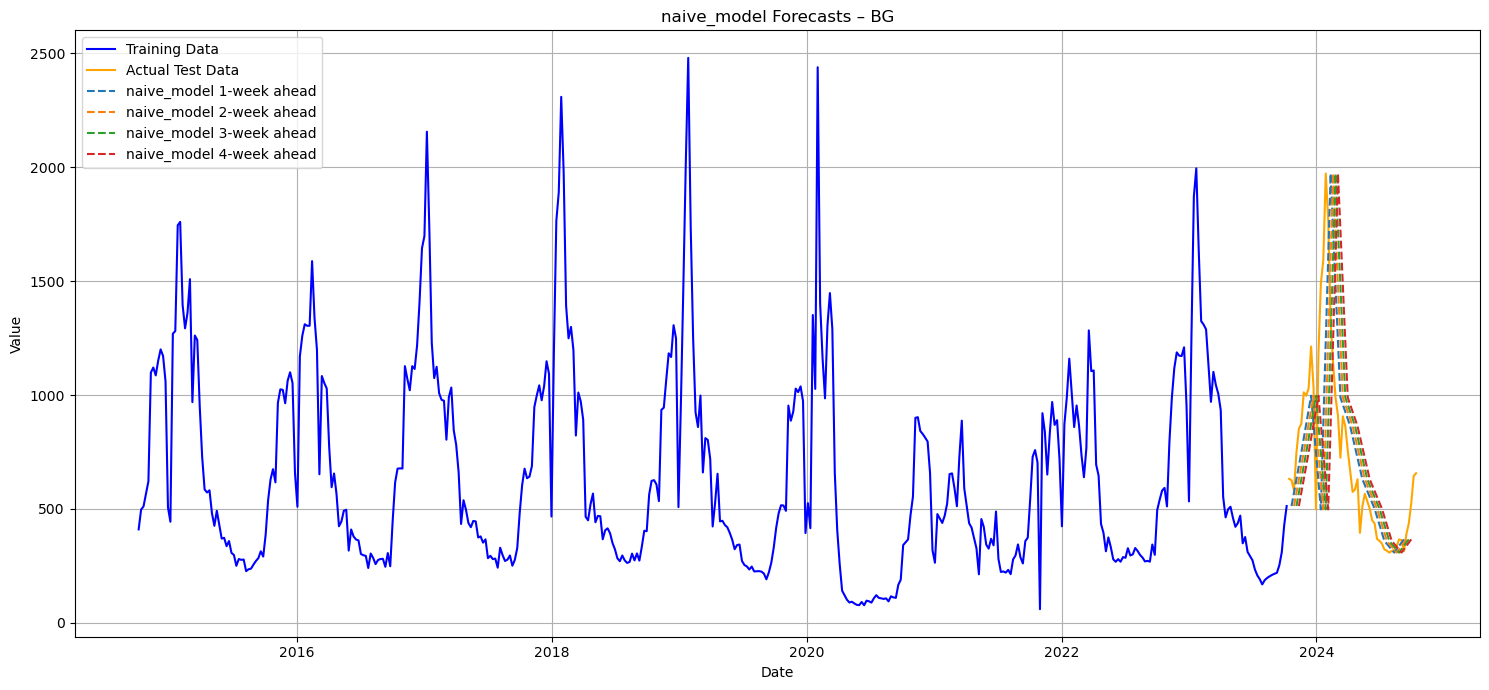

RO


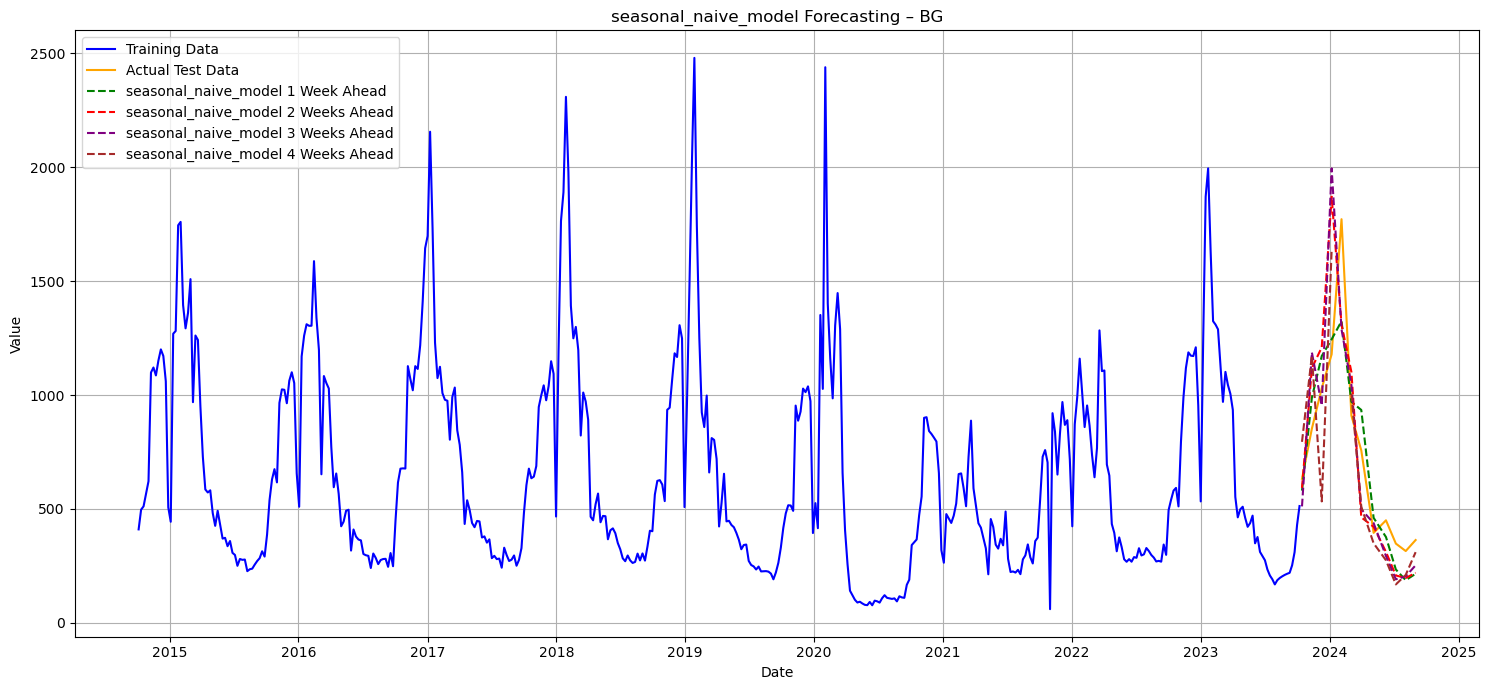

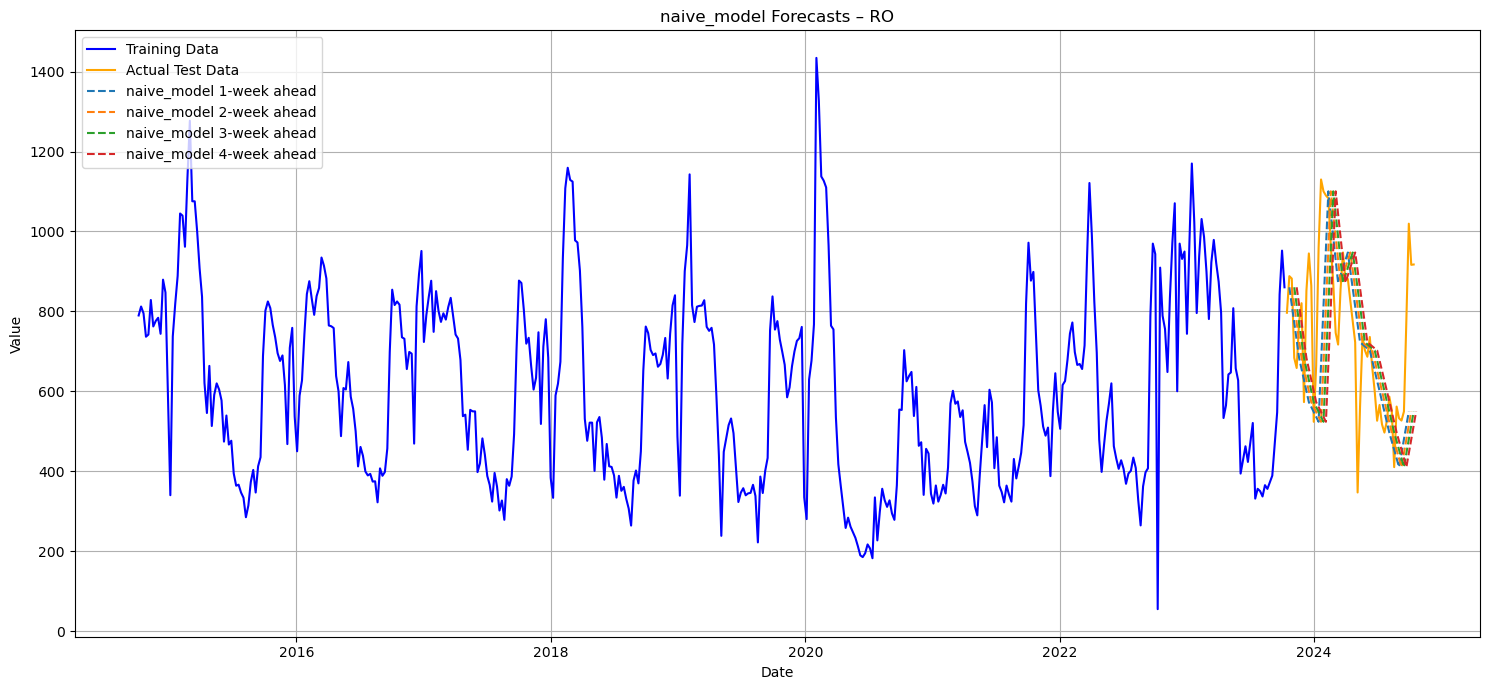

LV


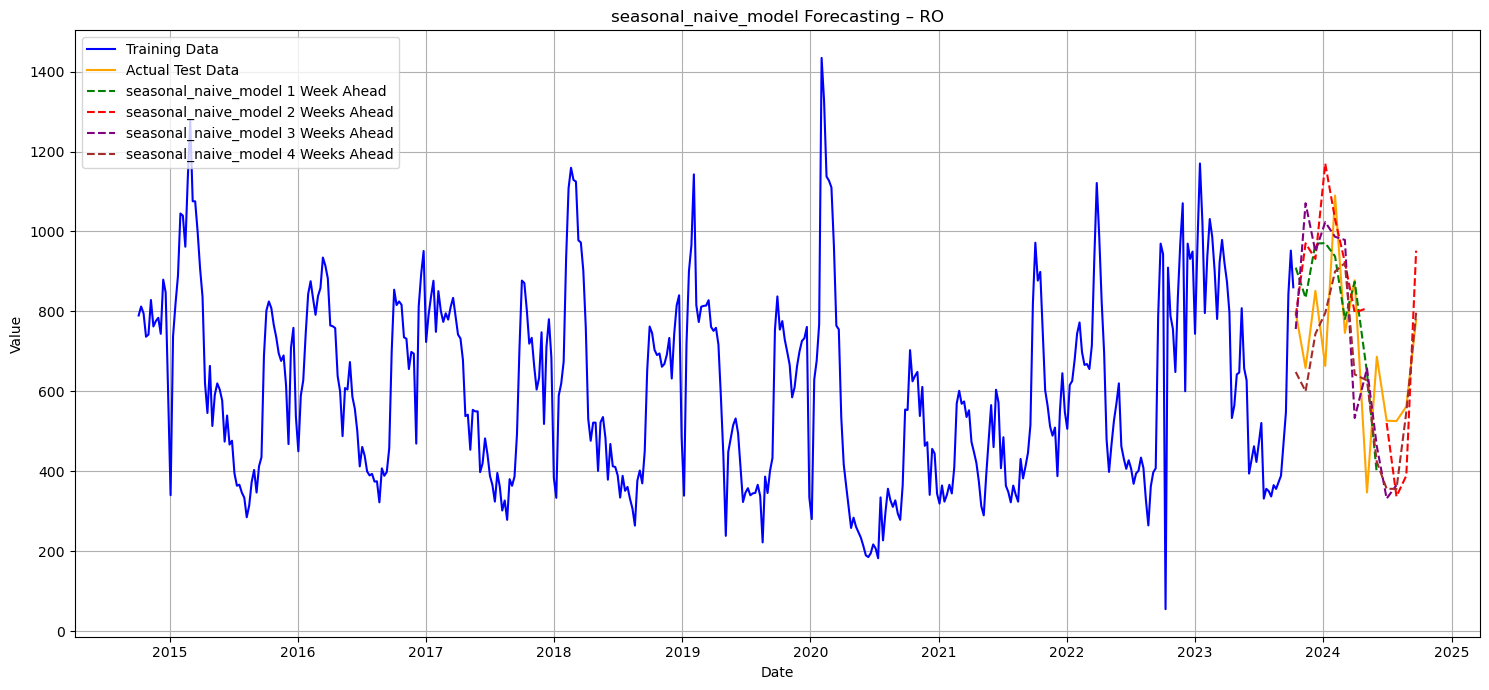

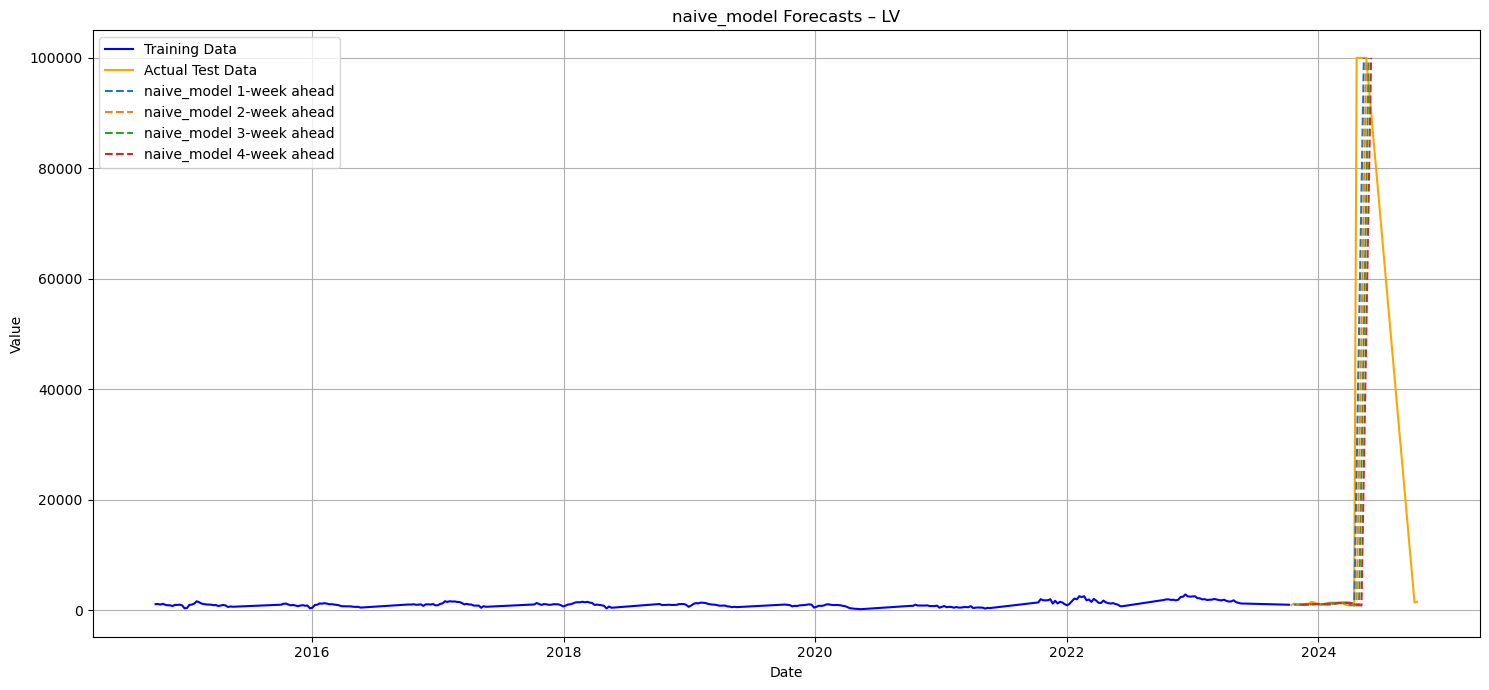

BE


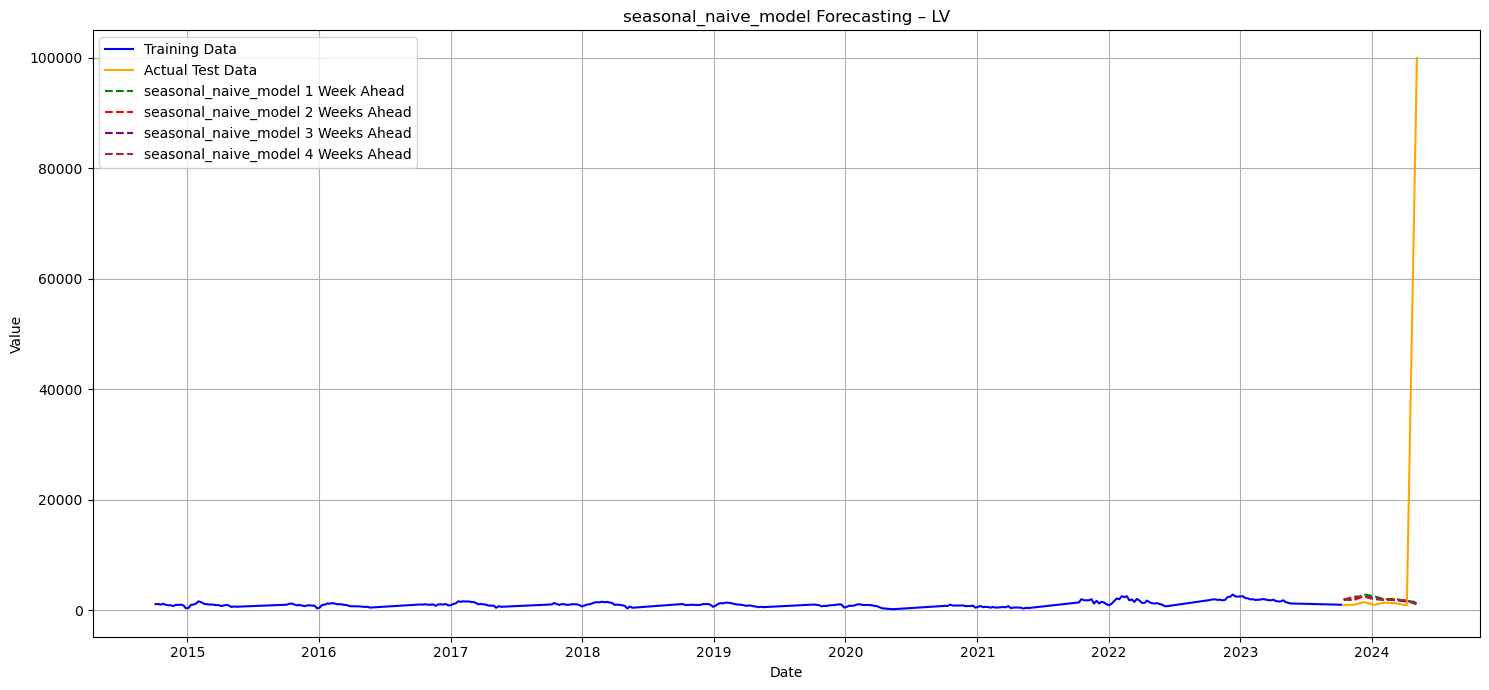

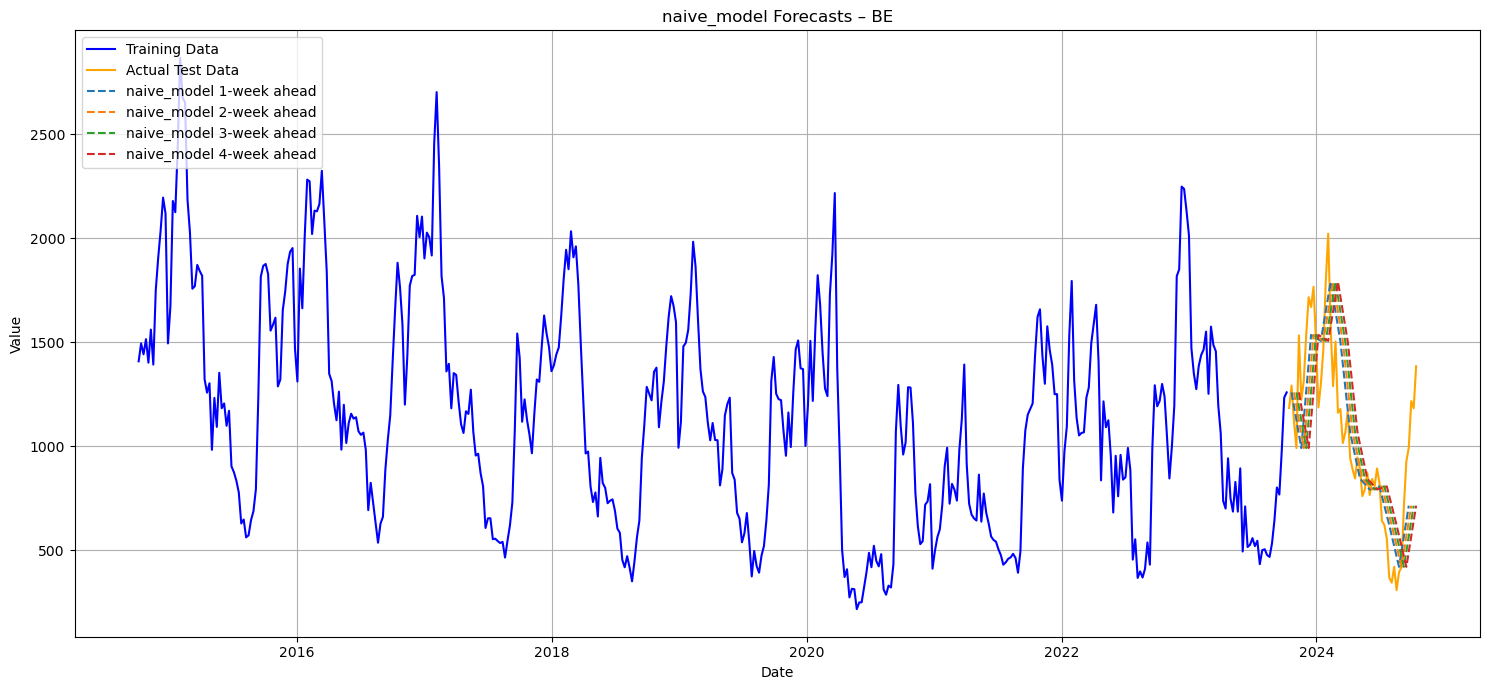

LT


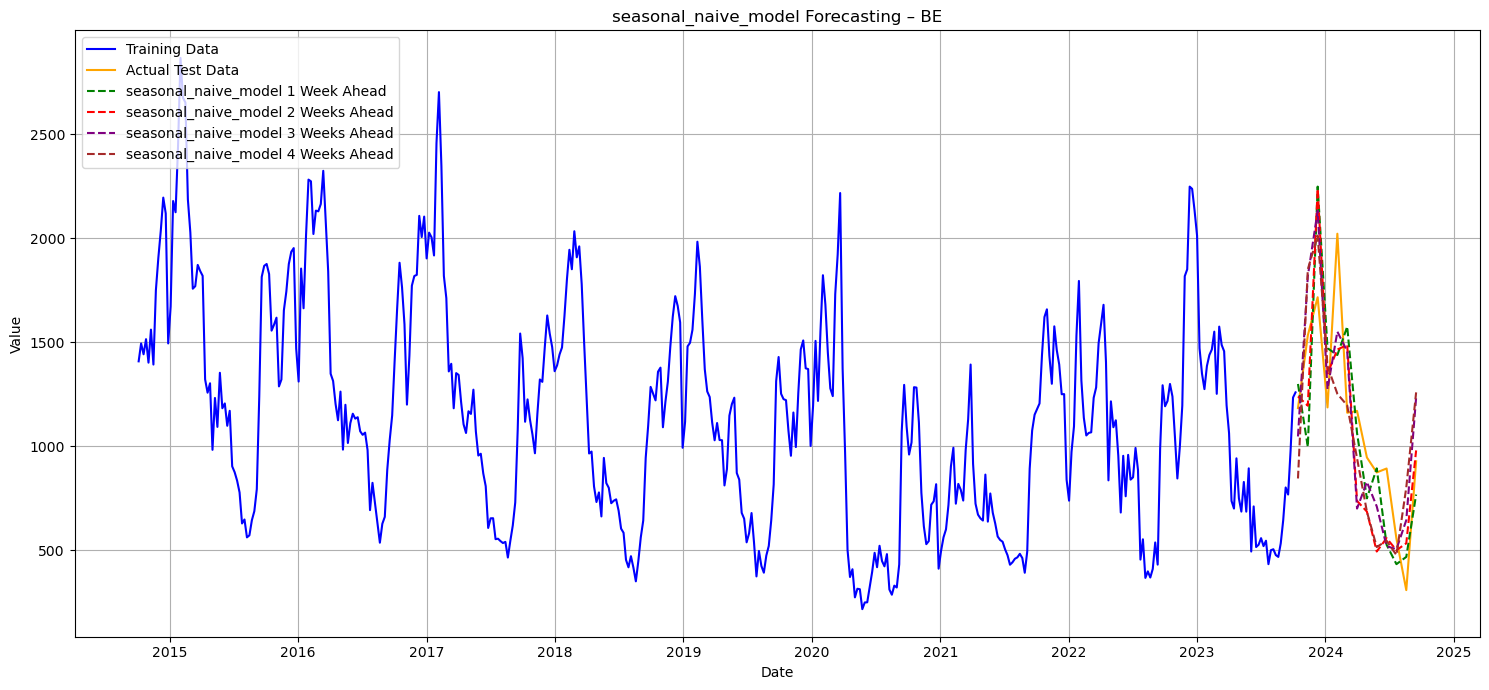

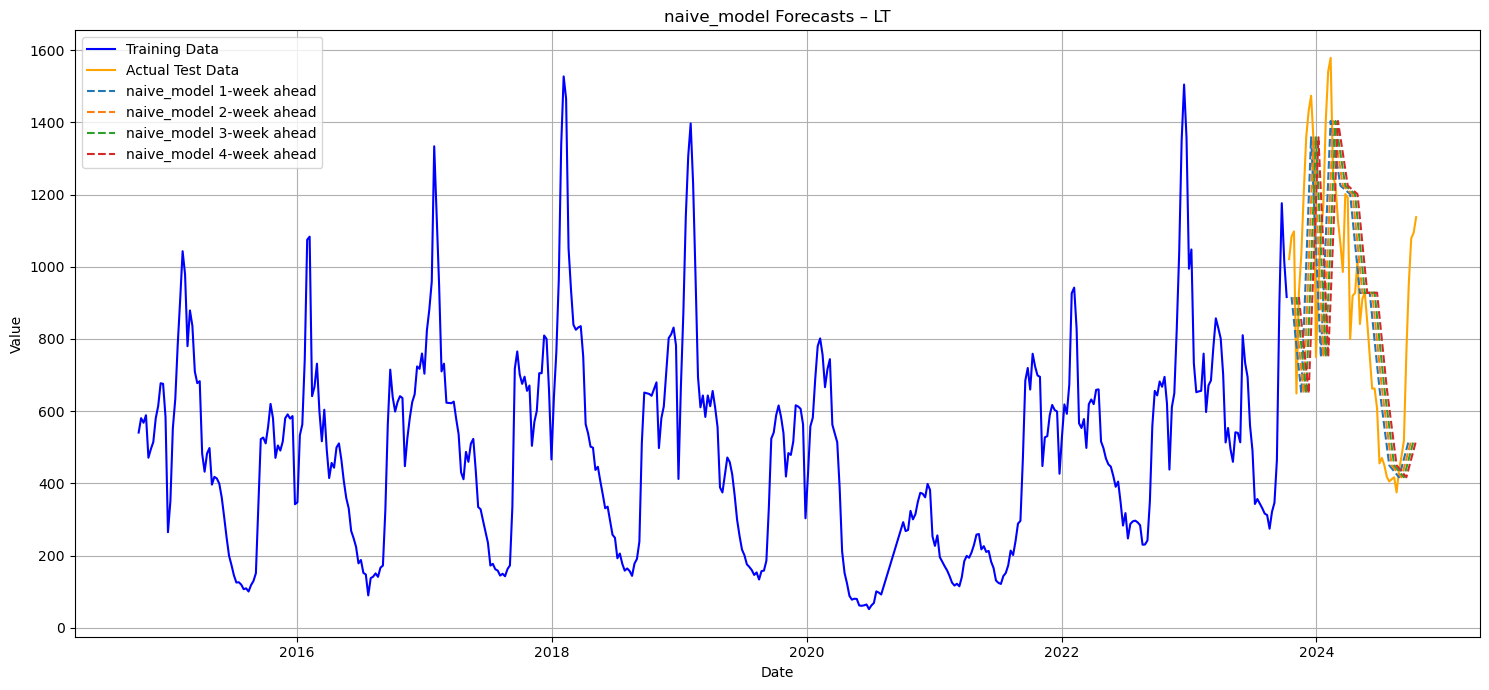

DE


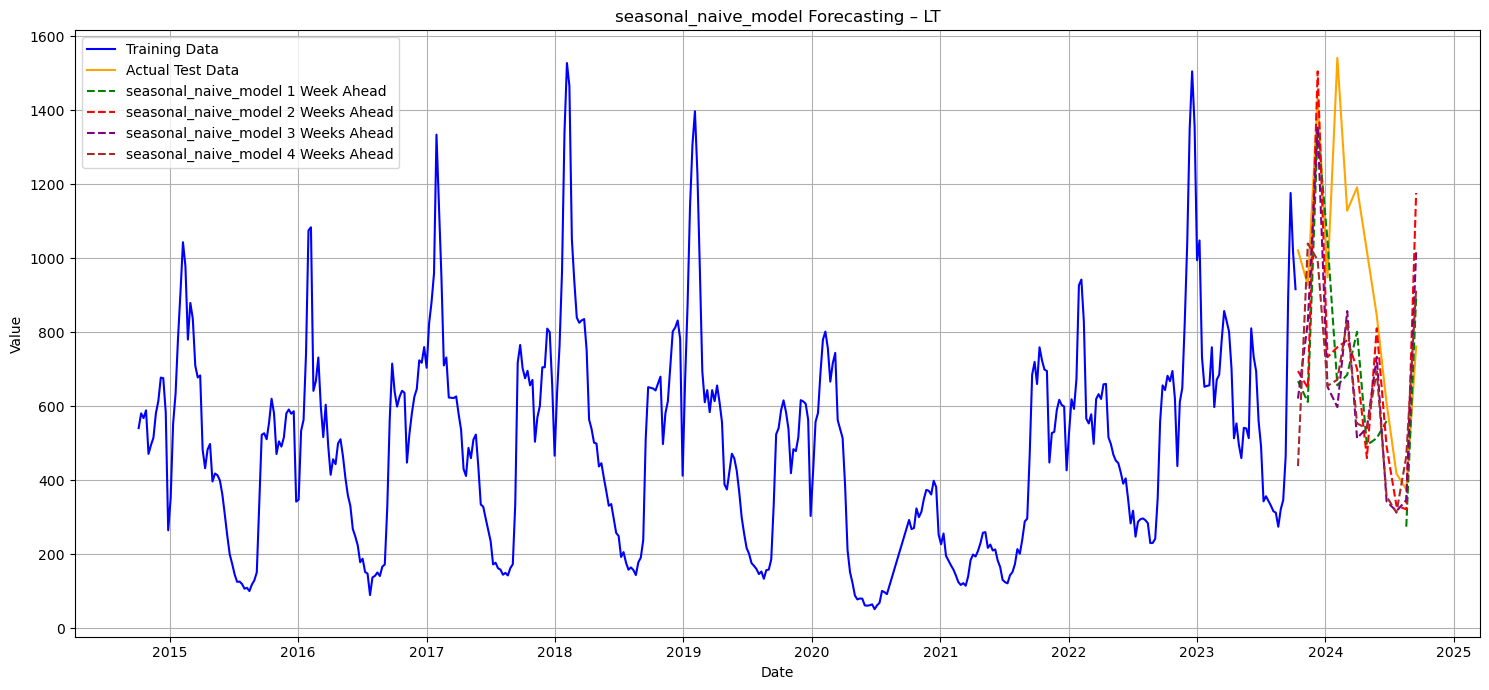

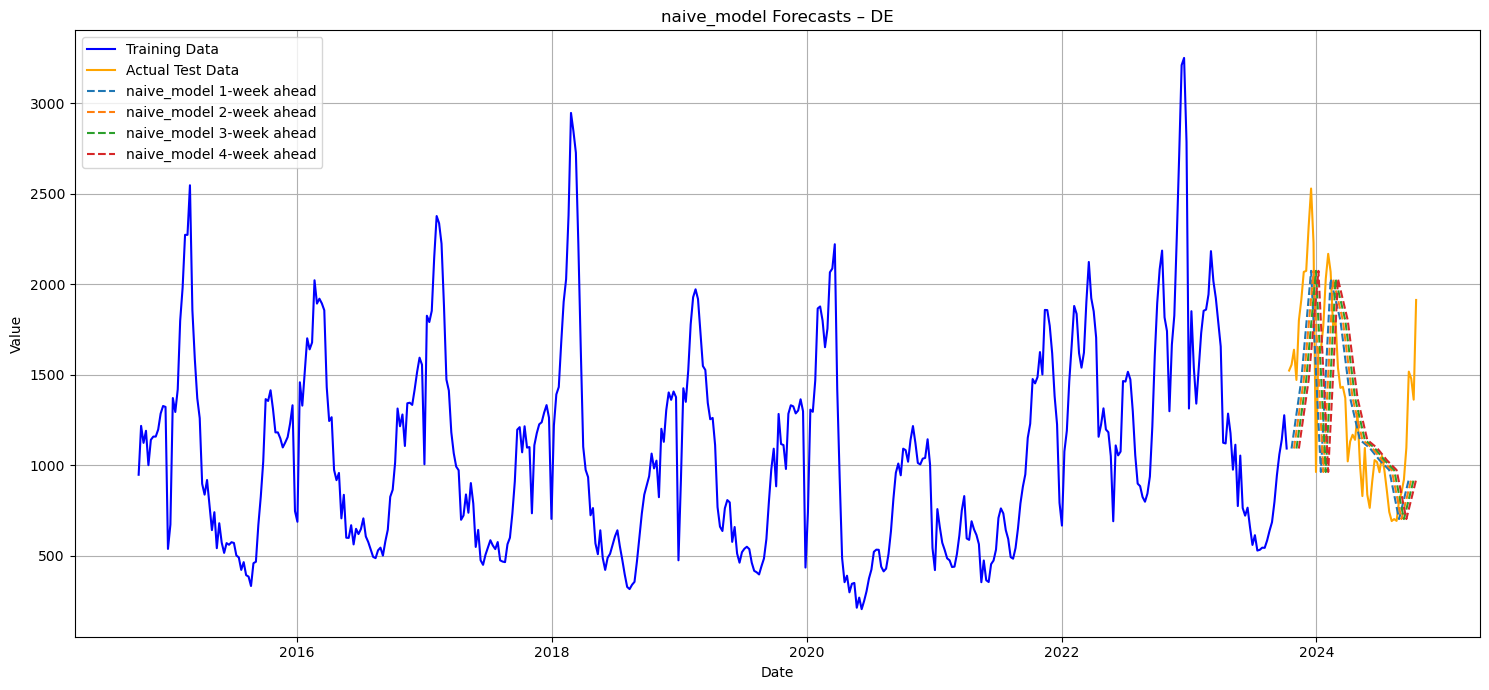

FR


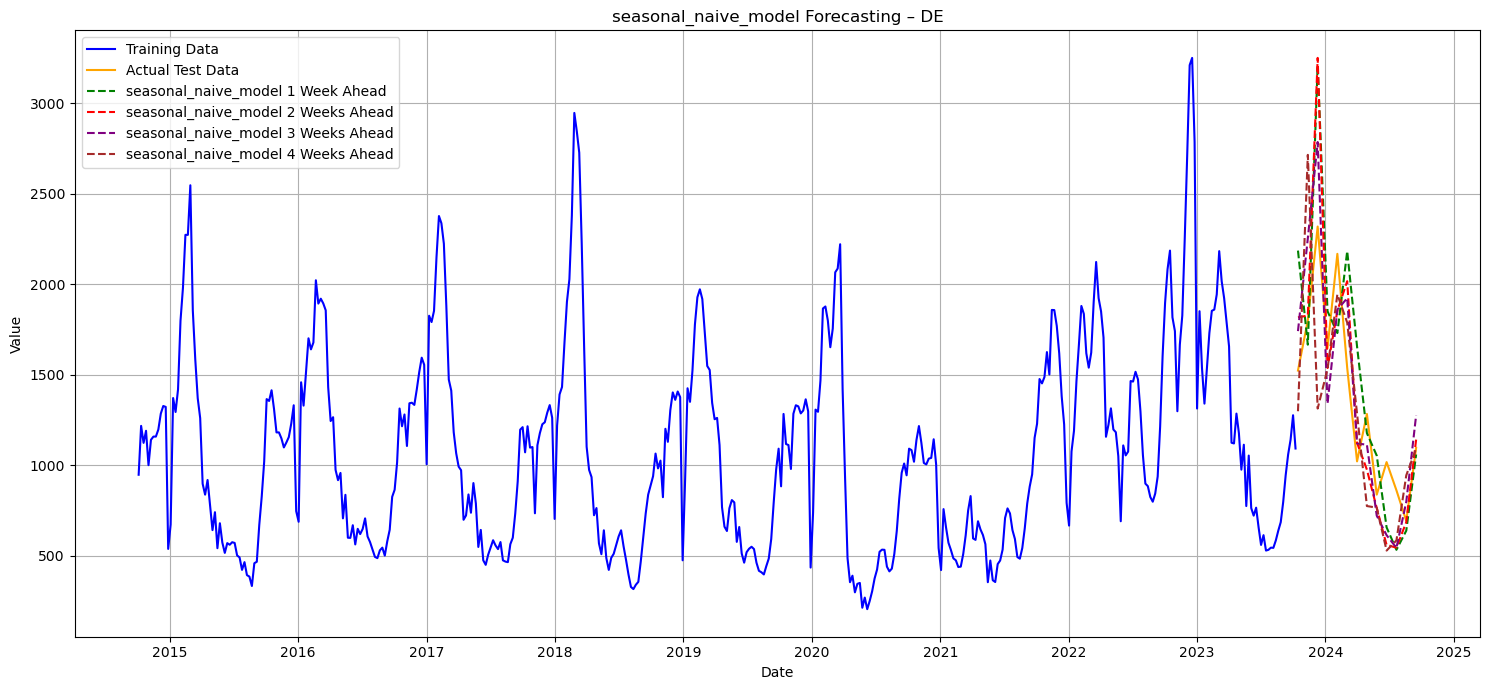

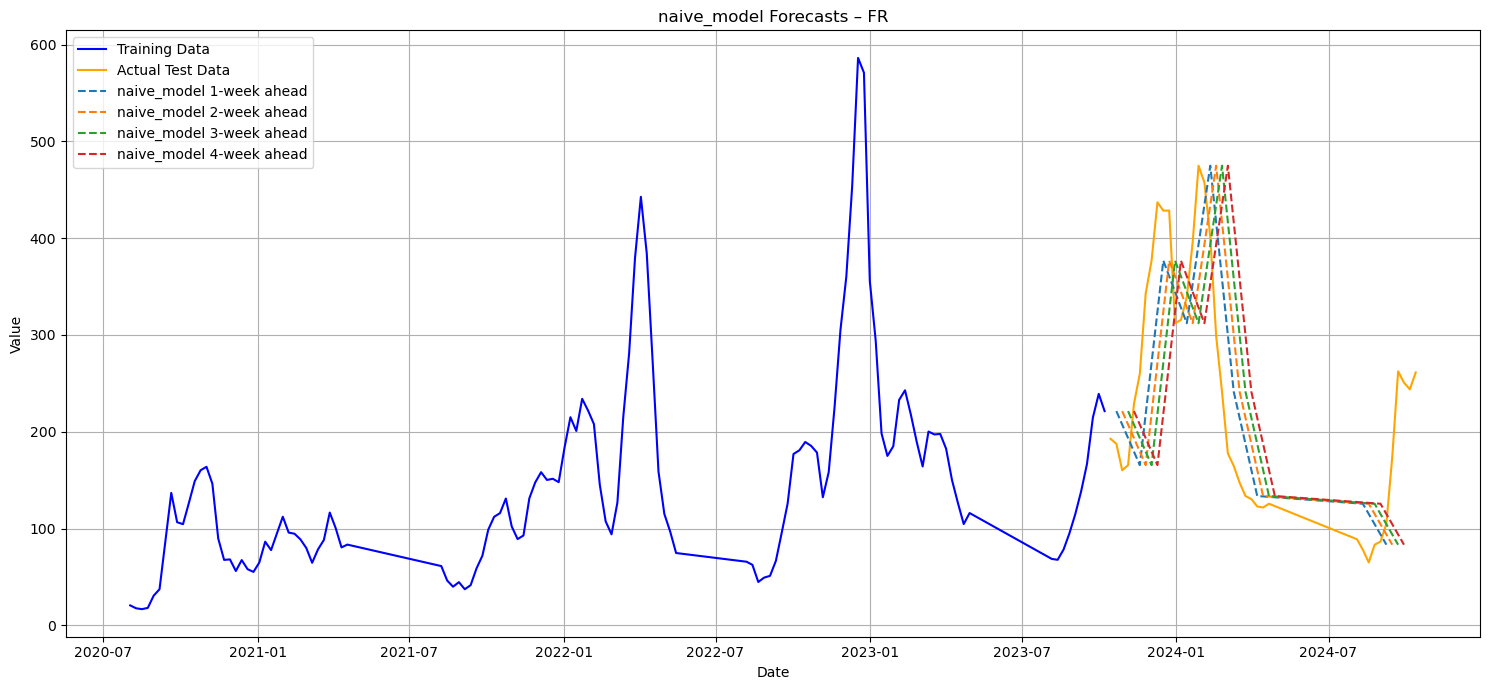

ES


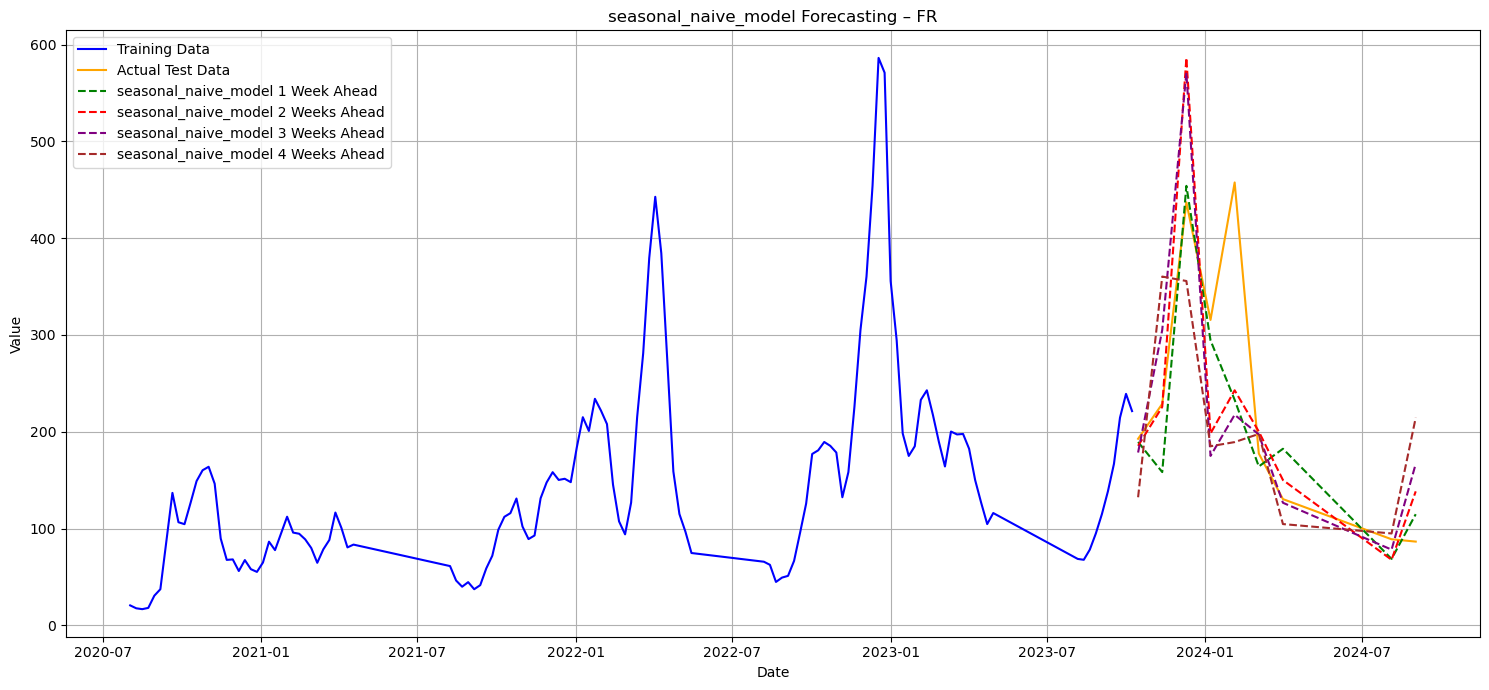

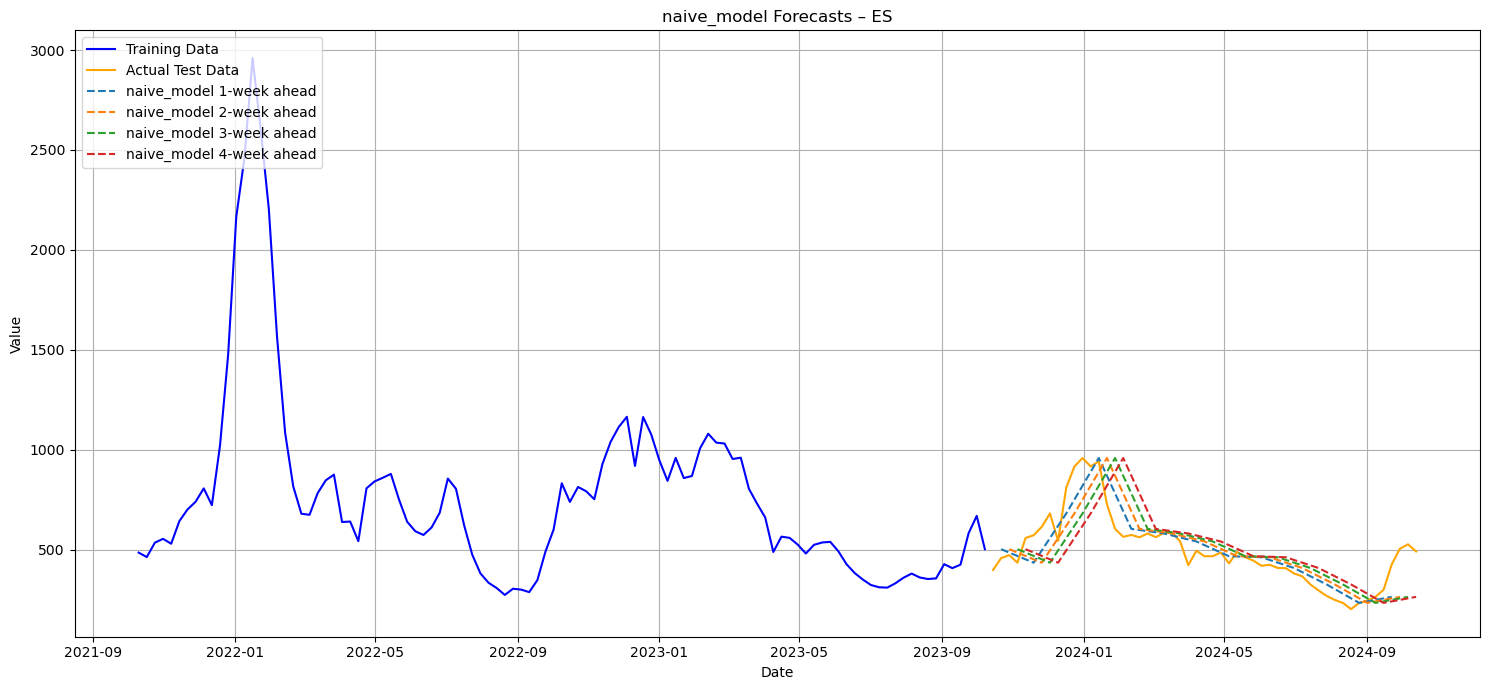

HU


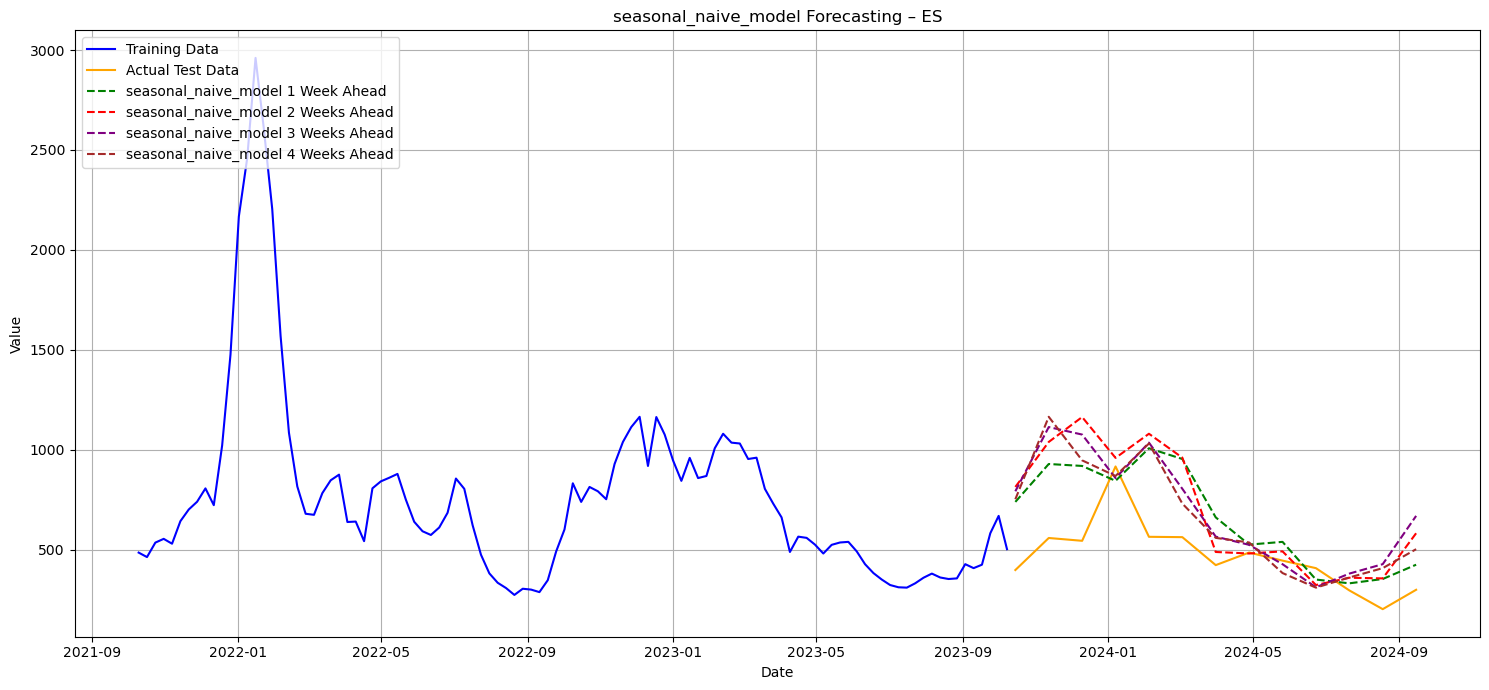

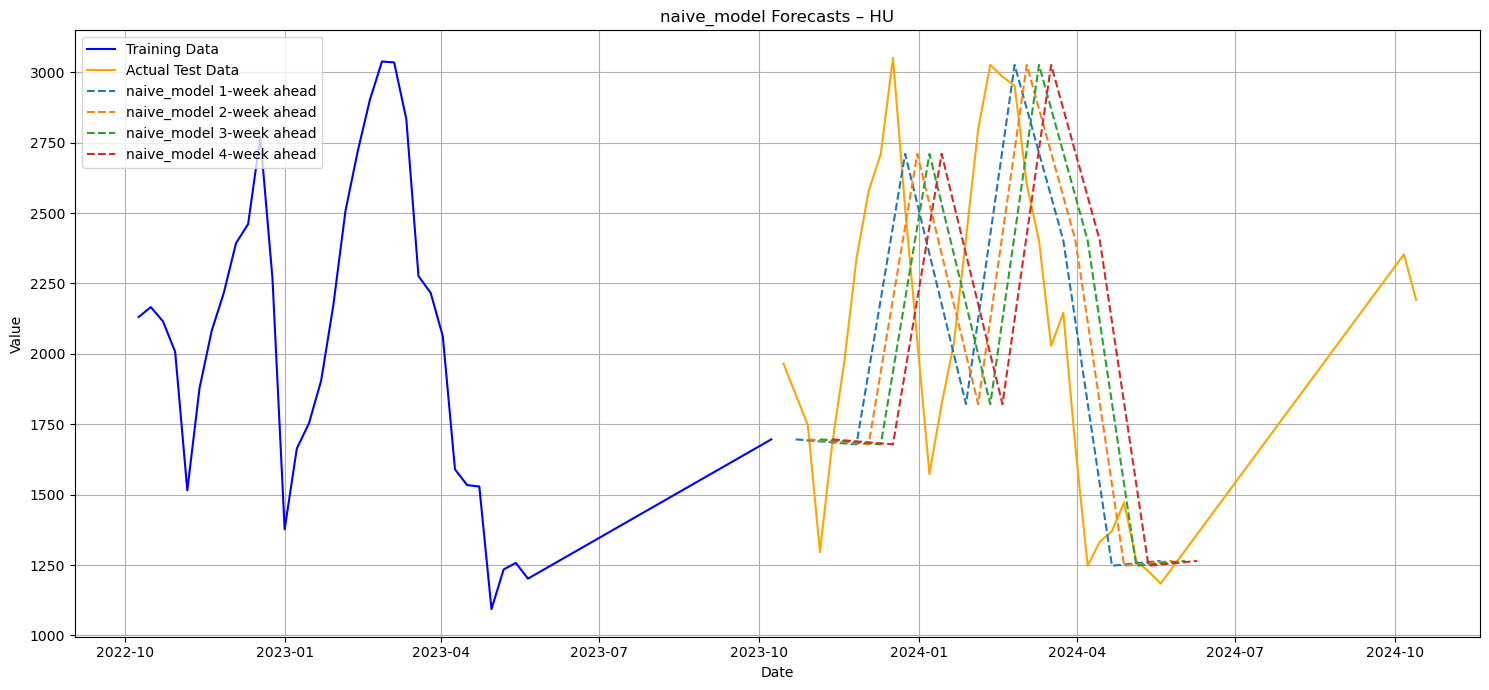

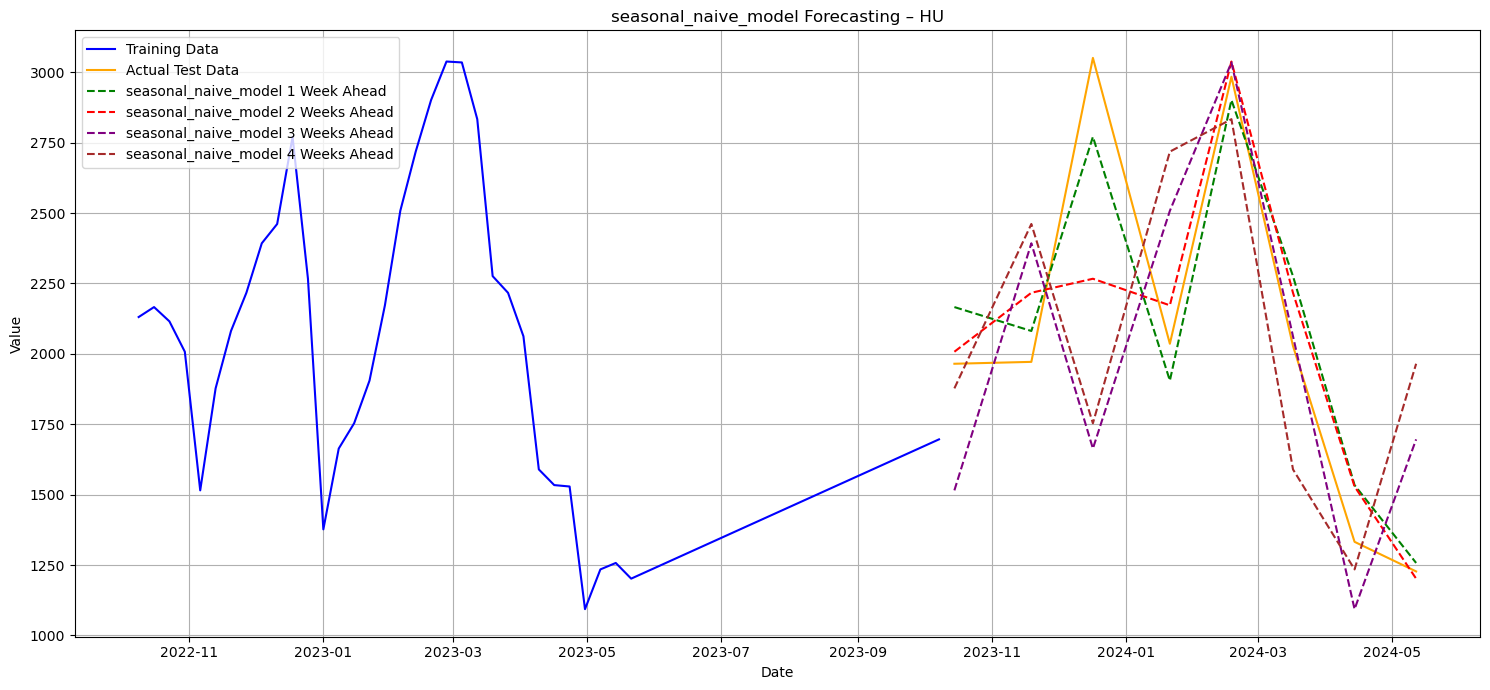

In [173]:
for i in name_ari:
    print(i)
    train_ari,test_ari = train_data(ari,i,'2023-10-13')
    seasonal_test_ari,mape_ari = seasonal_naive_models_1_4_week_rolling(train_ari, test_ari, i, mape_ari, horizon=4, lag=52)
    forecast_df,mape_ari = naive_rolling_4week_multi_forecast(train_ari,test_ari,i,mape_ari)
    plot_multi_horizon_forecasts(train_ari,test_ari,forecast_df,i,'naive_model')
    plot_train_test(train_ari,seasonal_test_ari,'seasonal_naive_model',i,'ari_seasonal_naive')
    

SI


C:\Users\flore\AppData\Local\Temp\ipykernel_13104\931820079.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape = pd.concat([


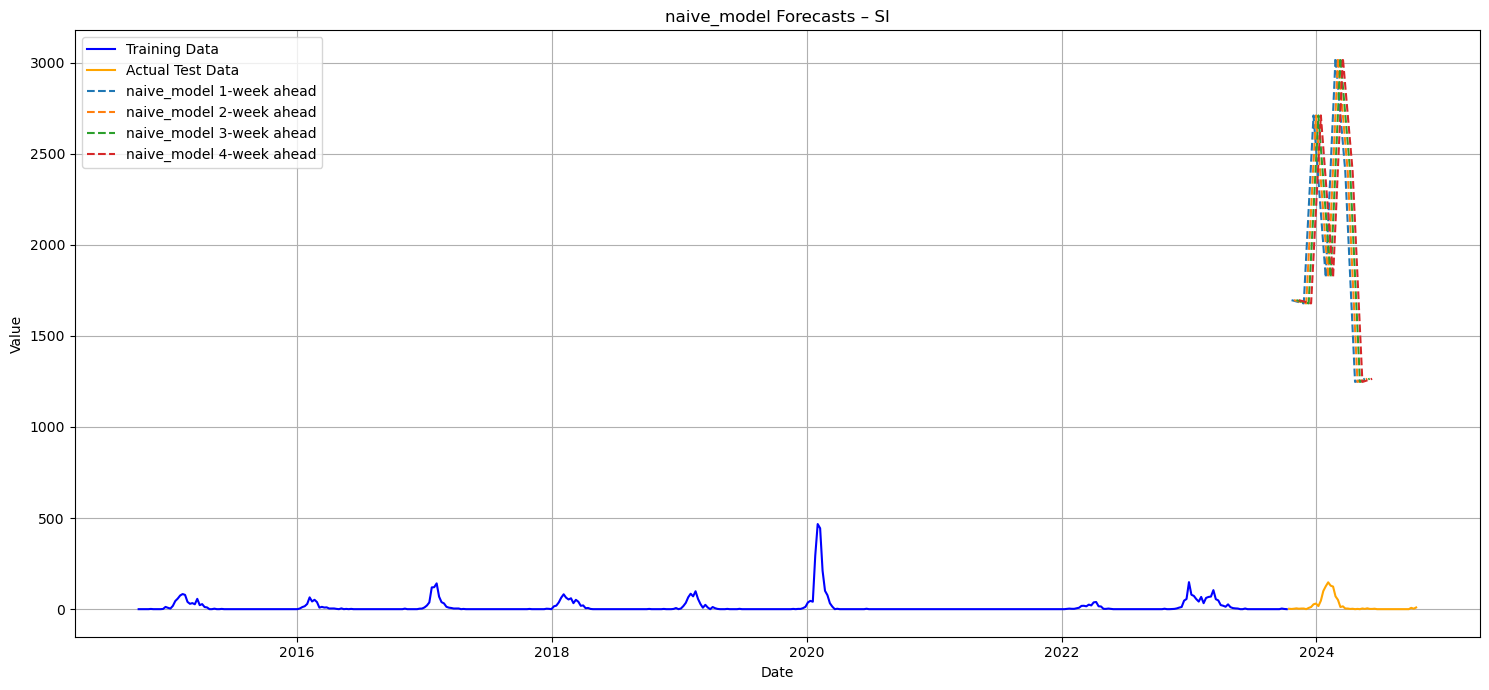

DK


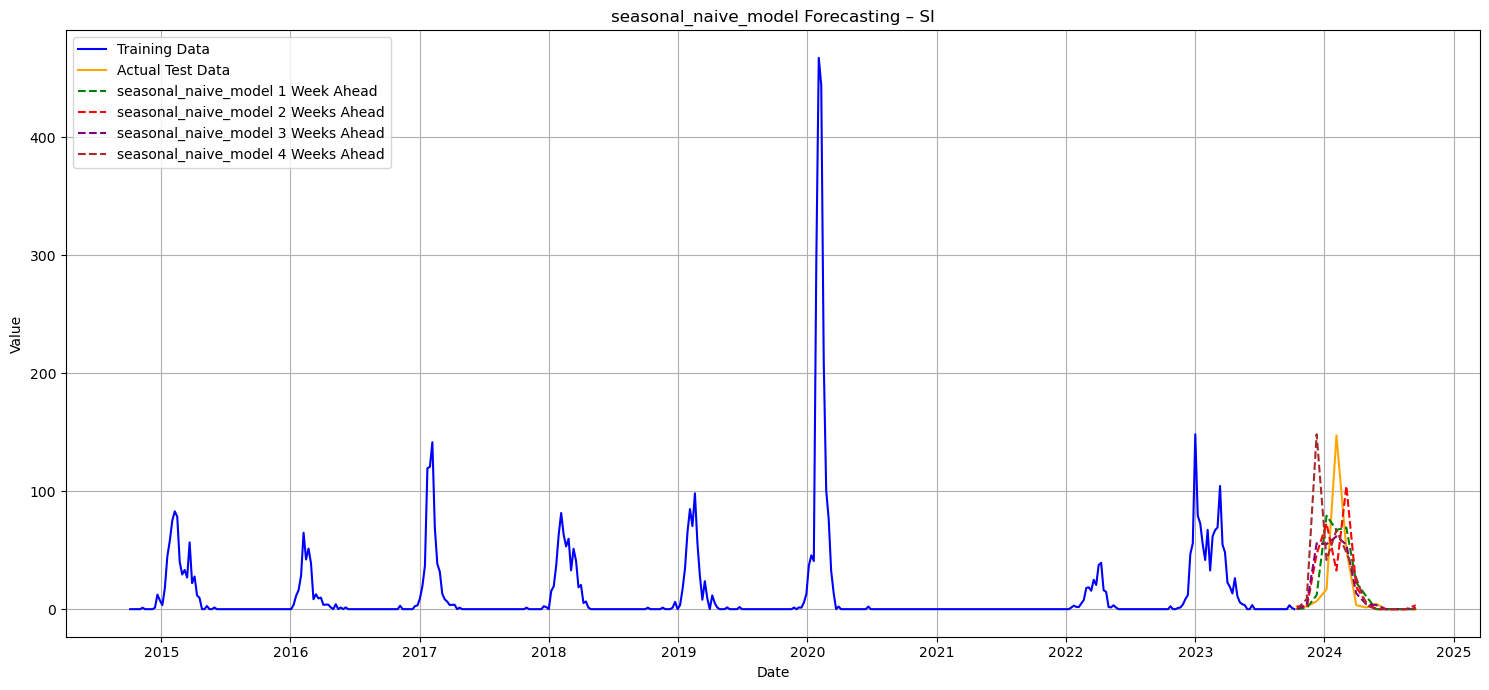

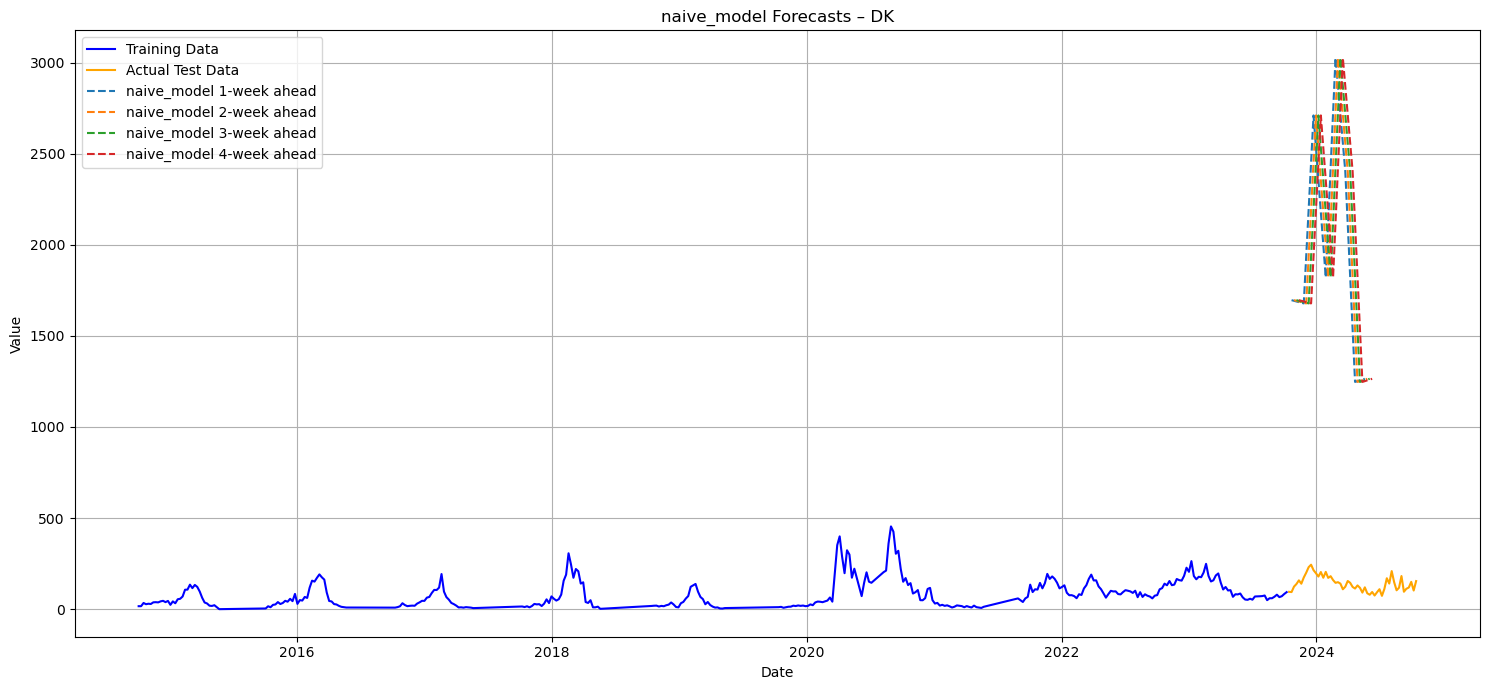

EE


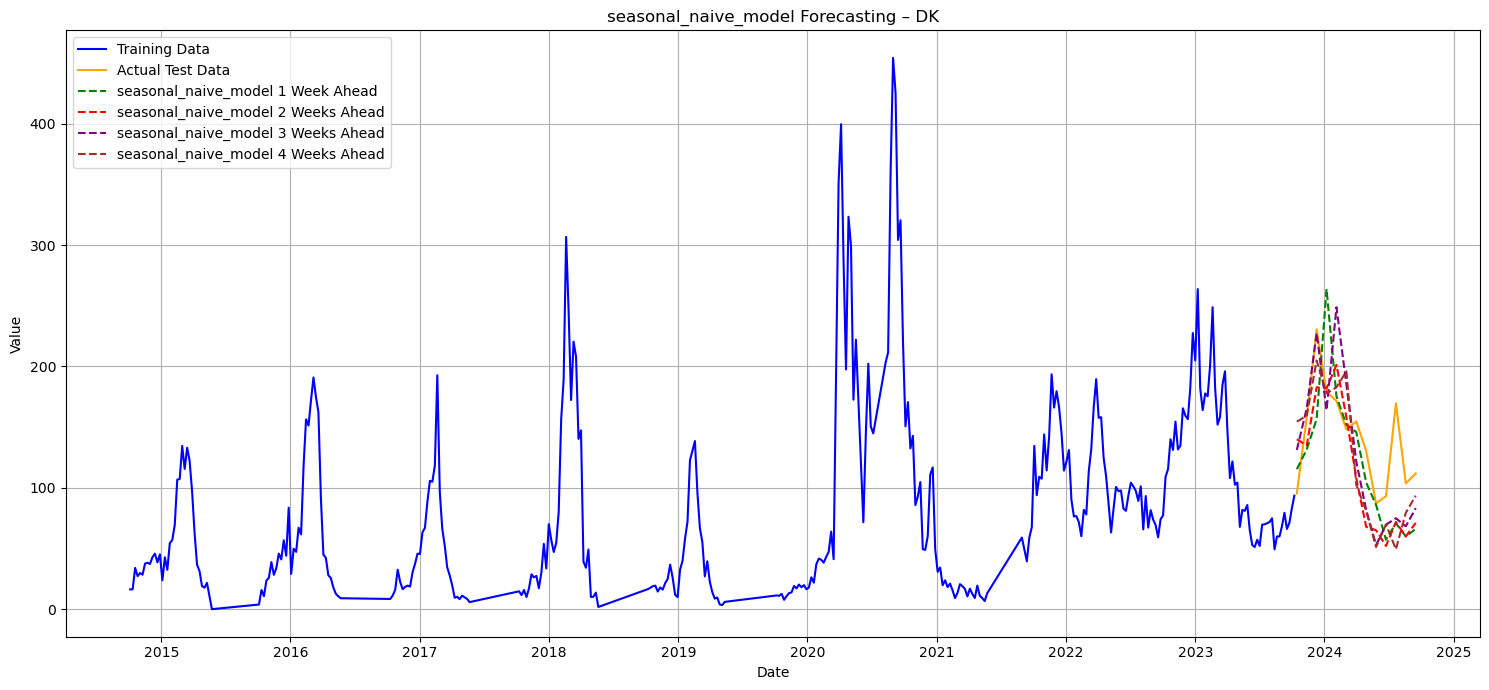

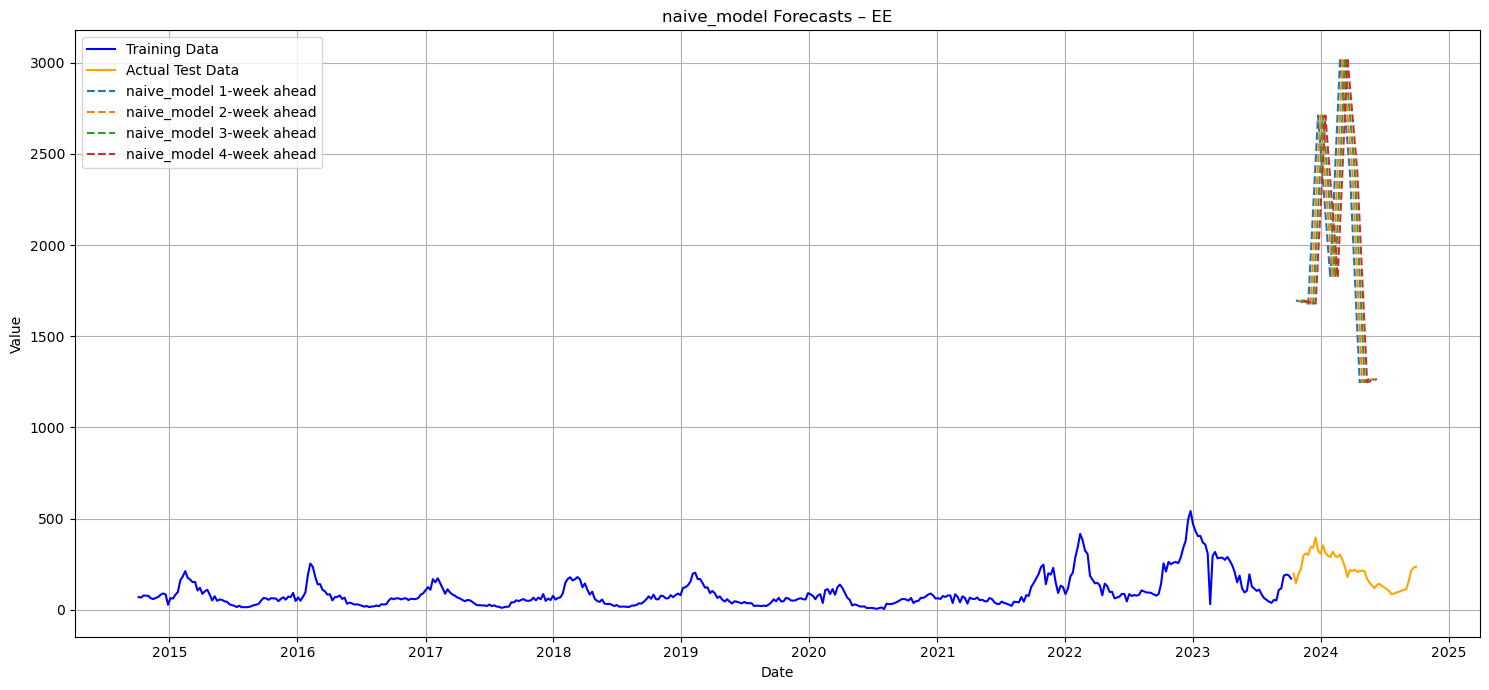

PL


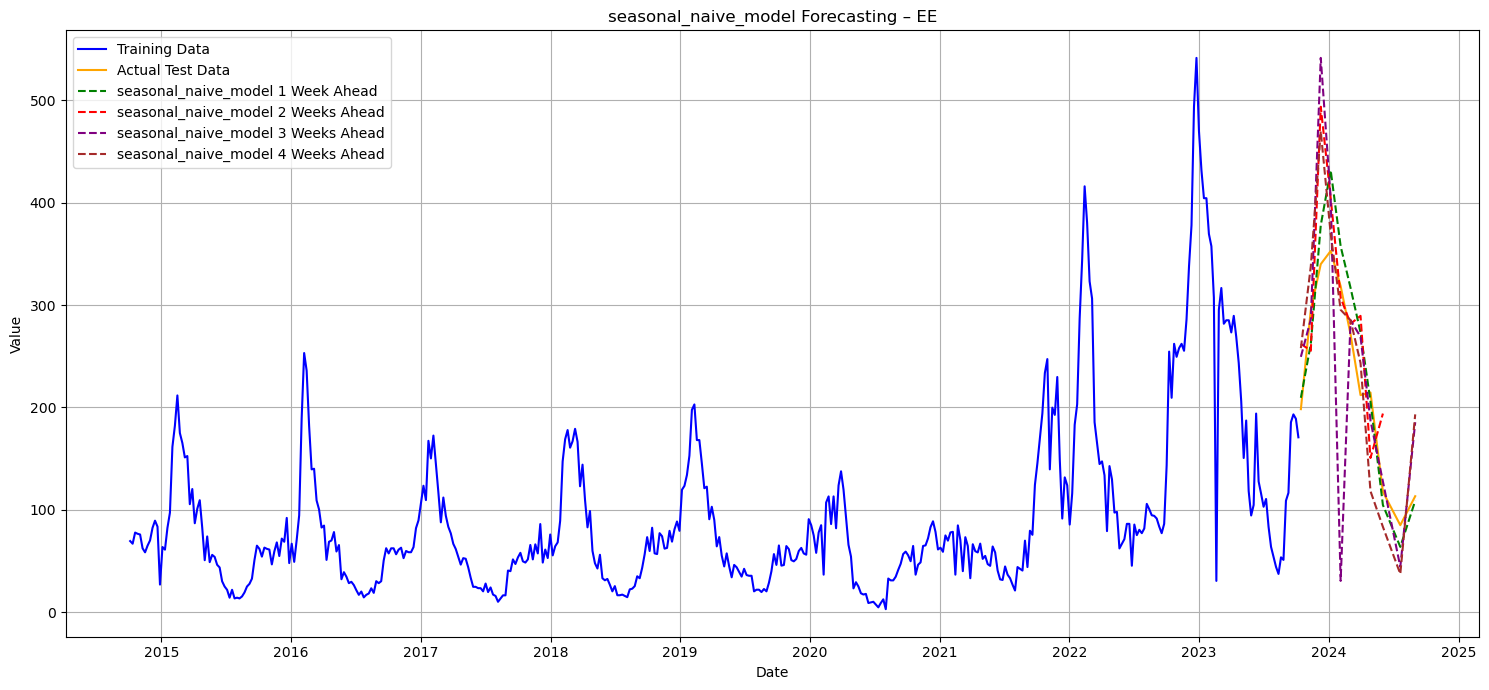

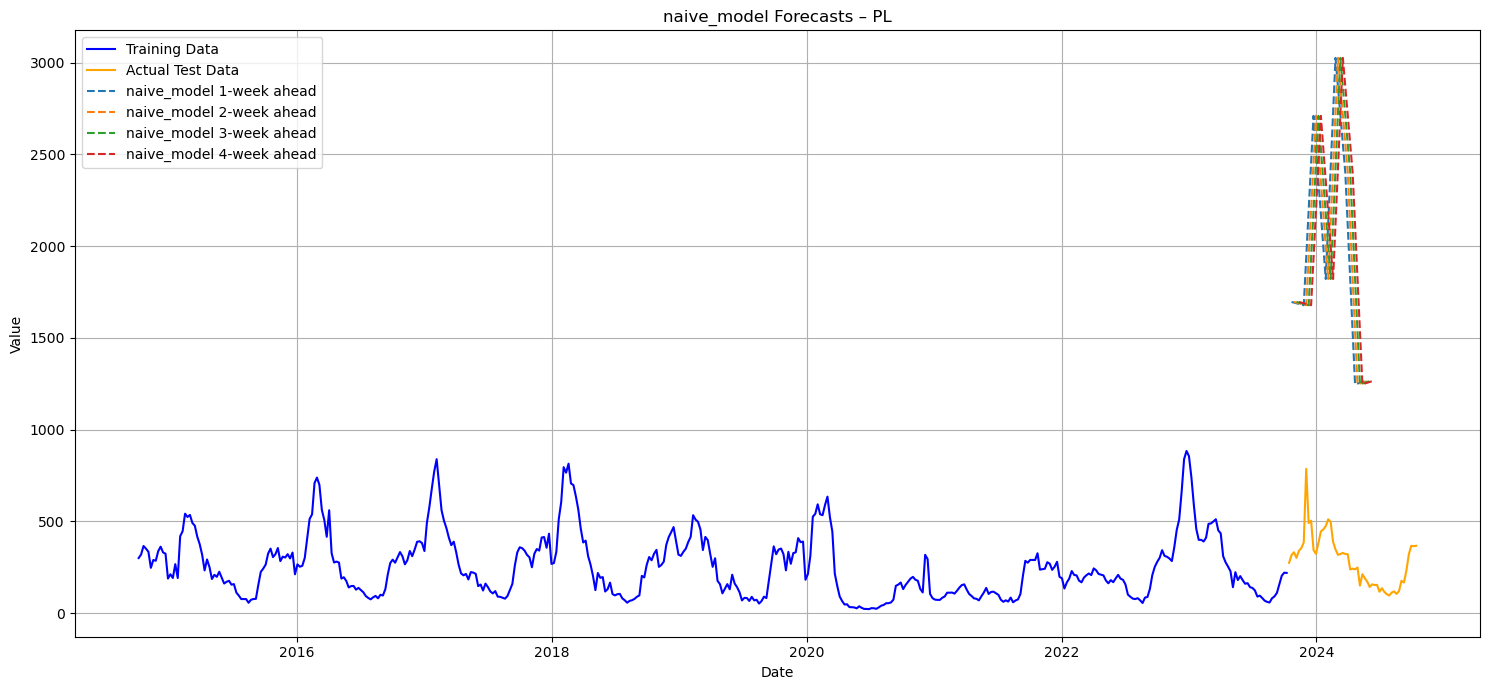

FR


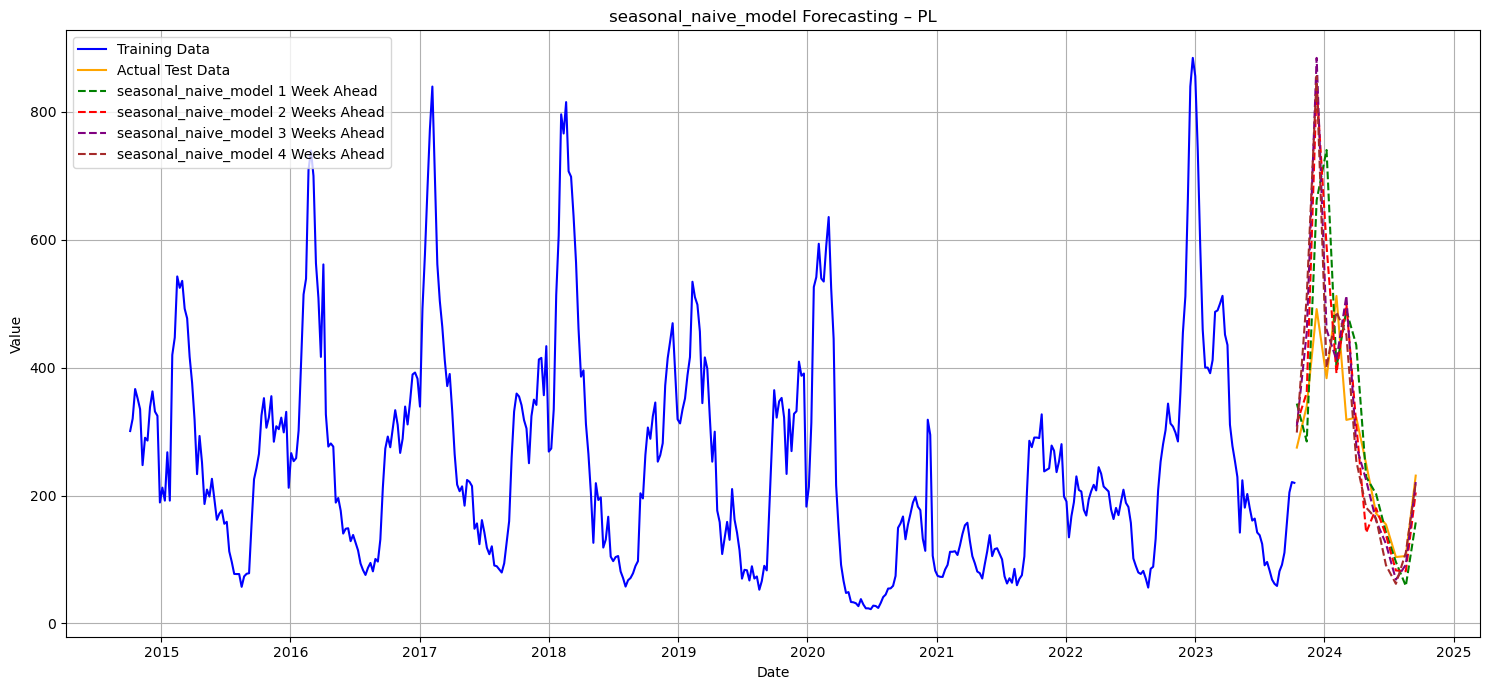

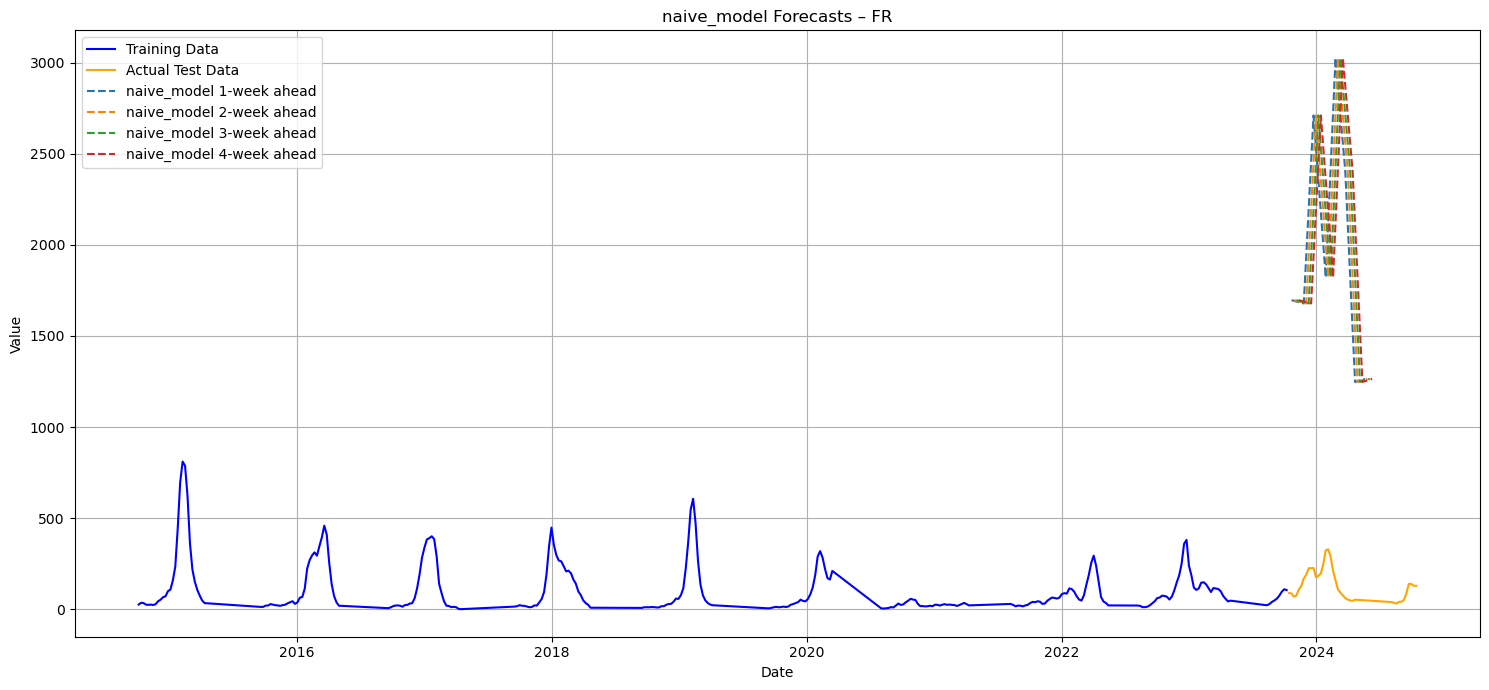

AT


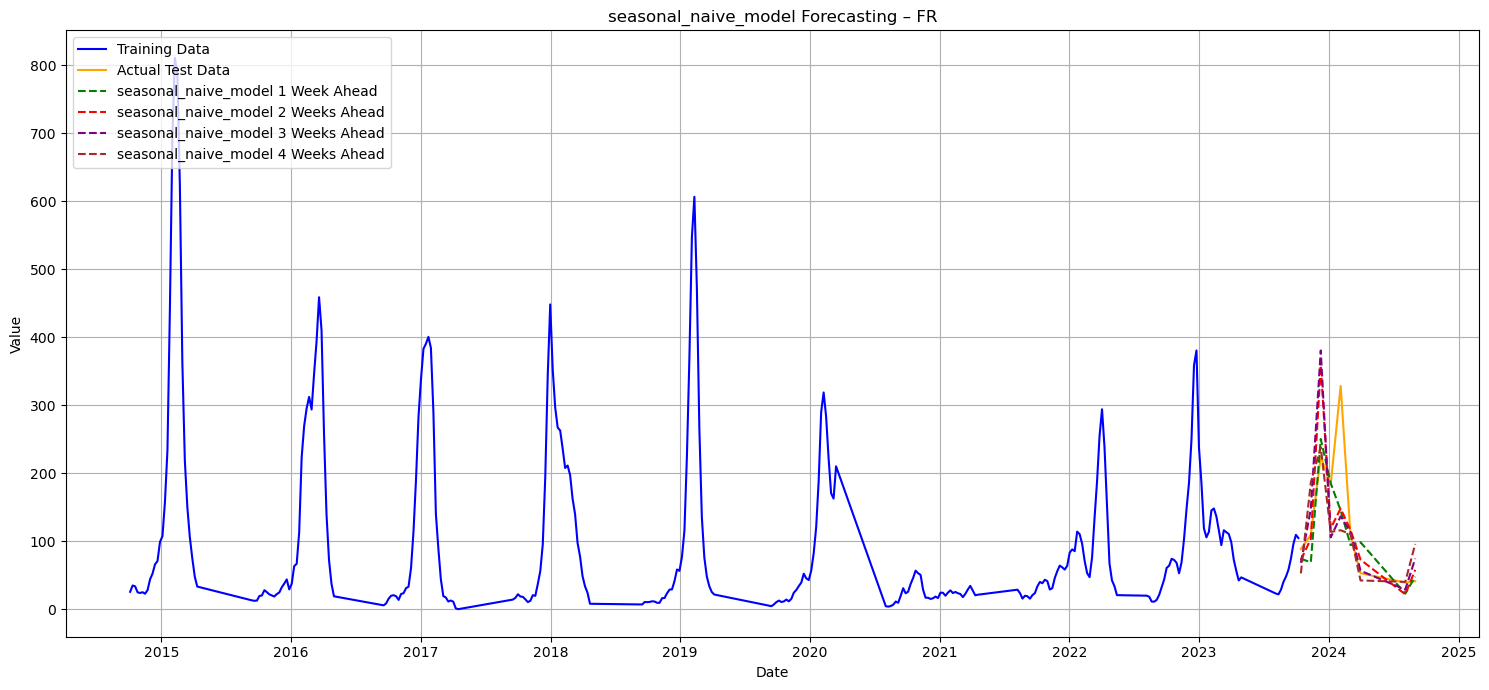

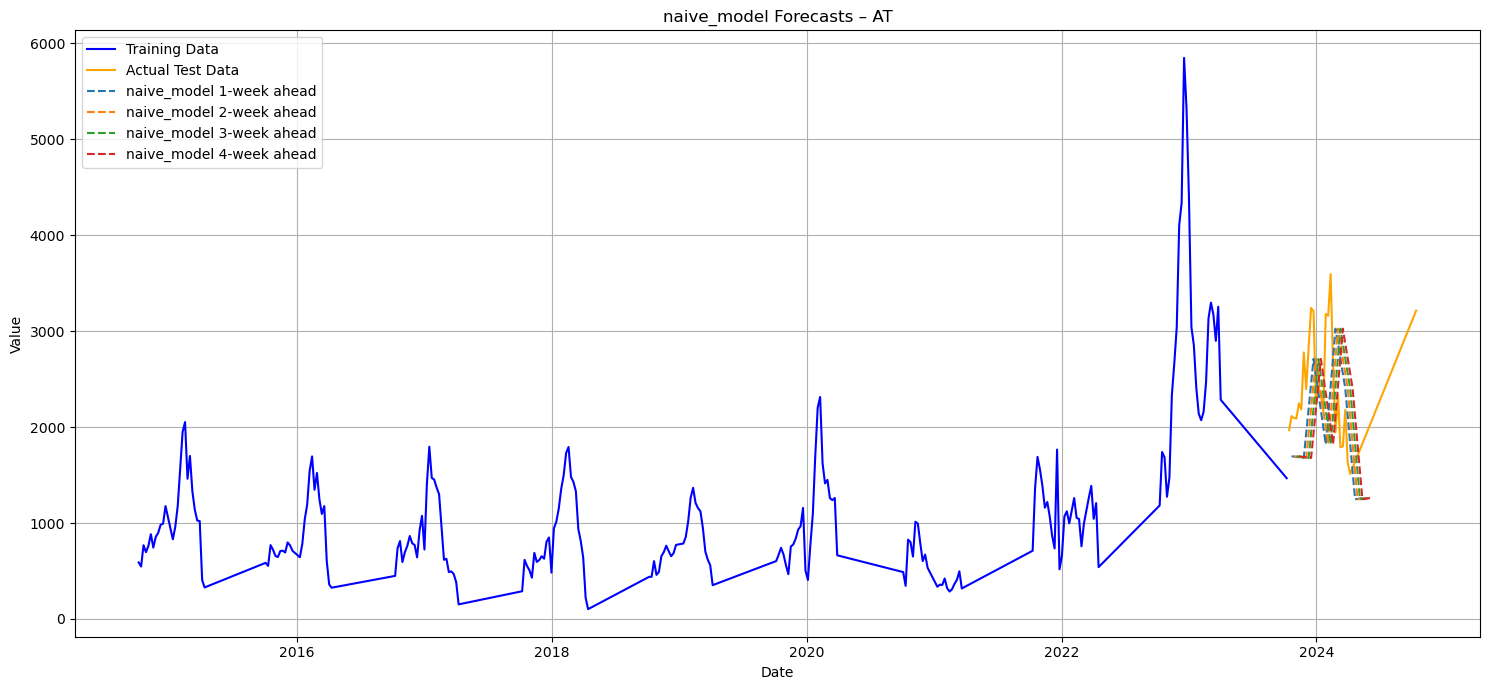

HR


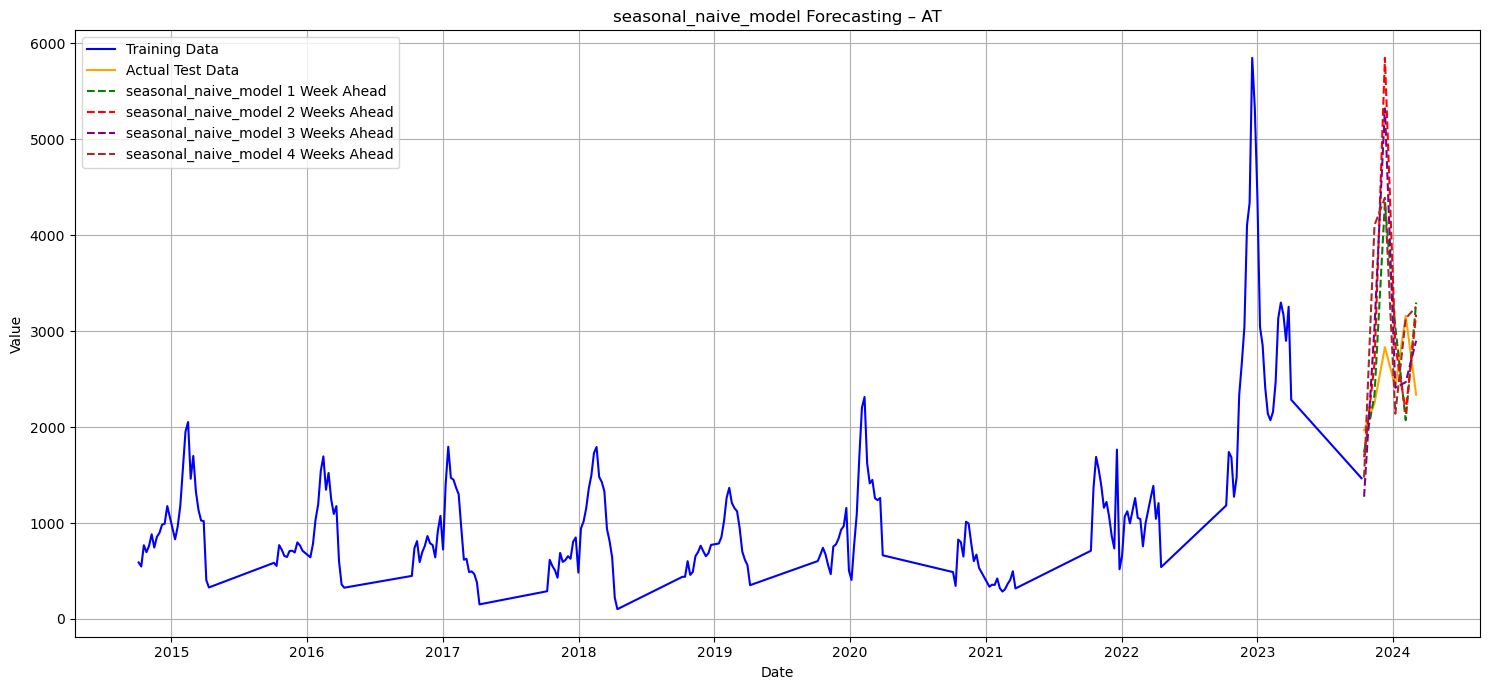

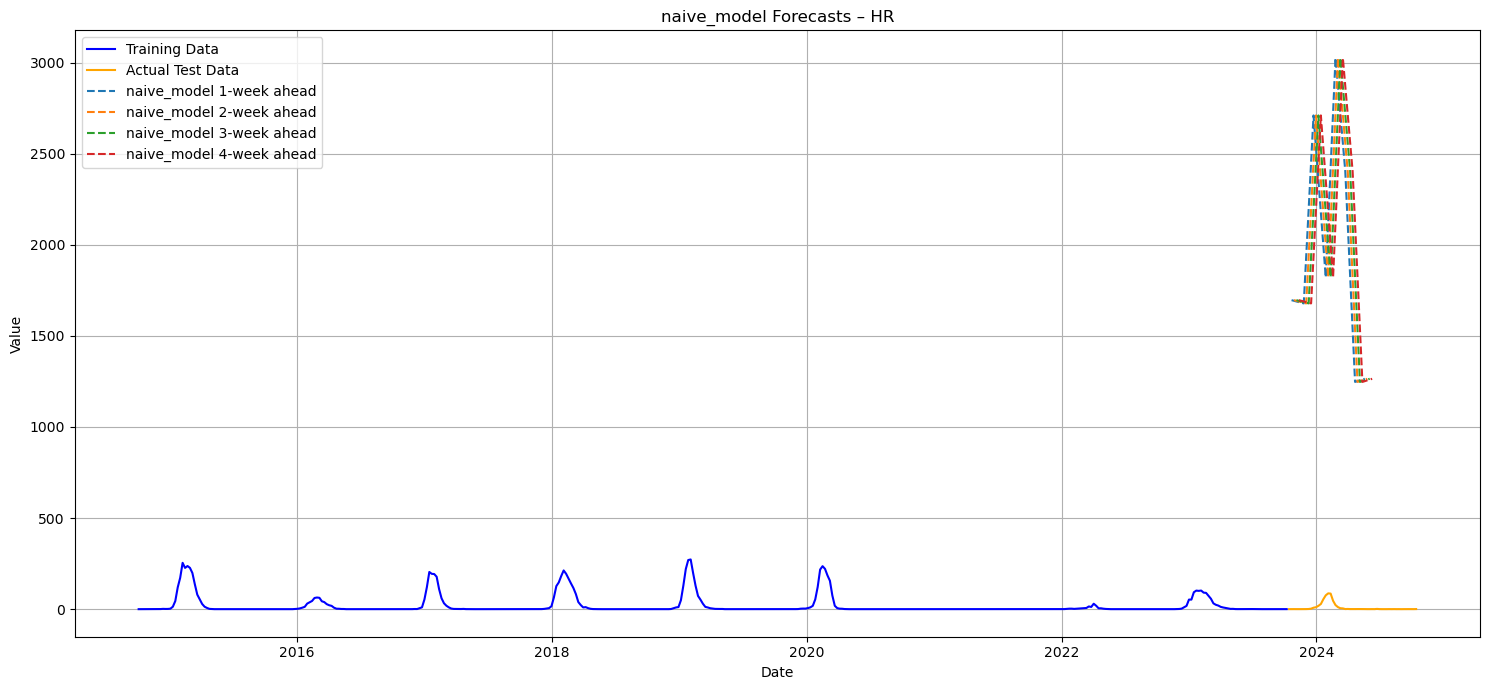

RO


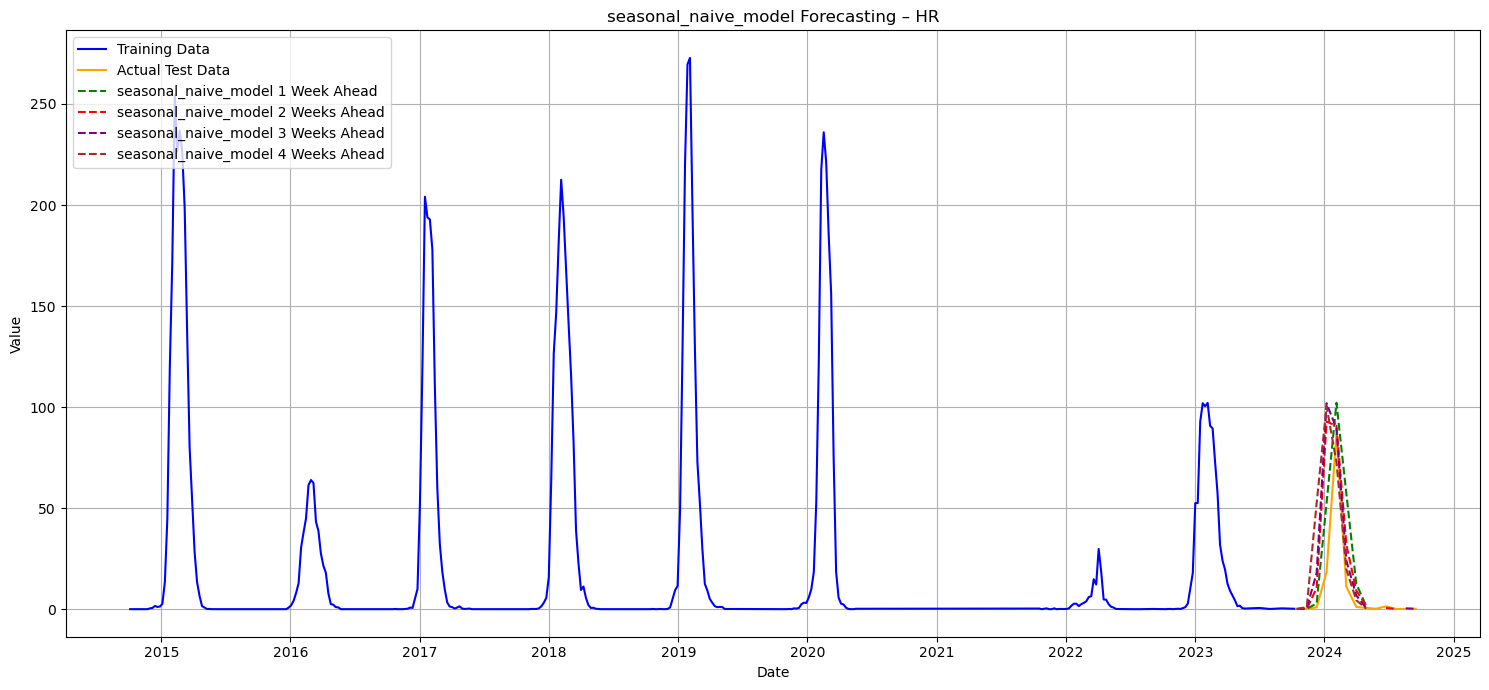

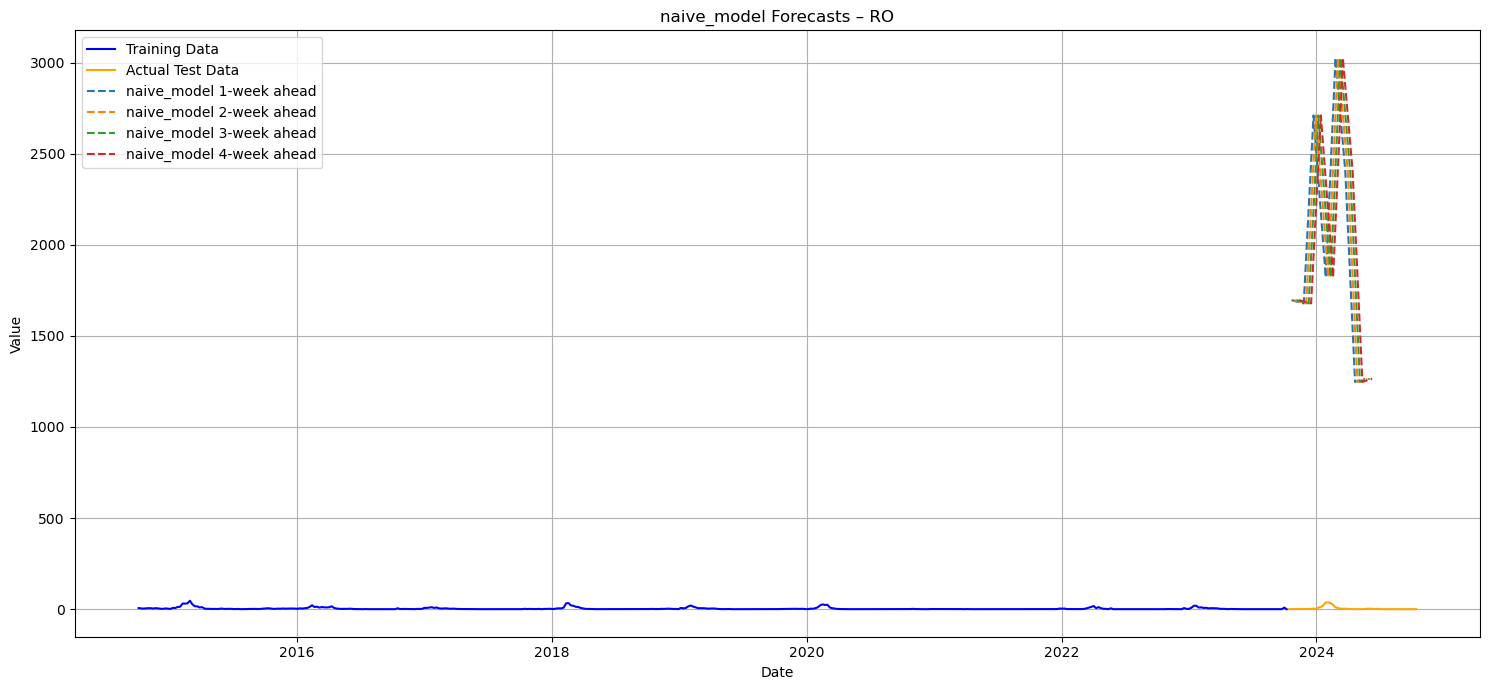

GR


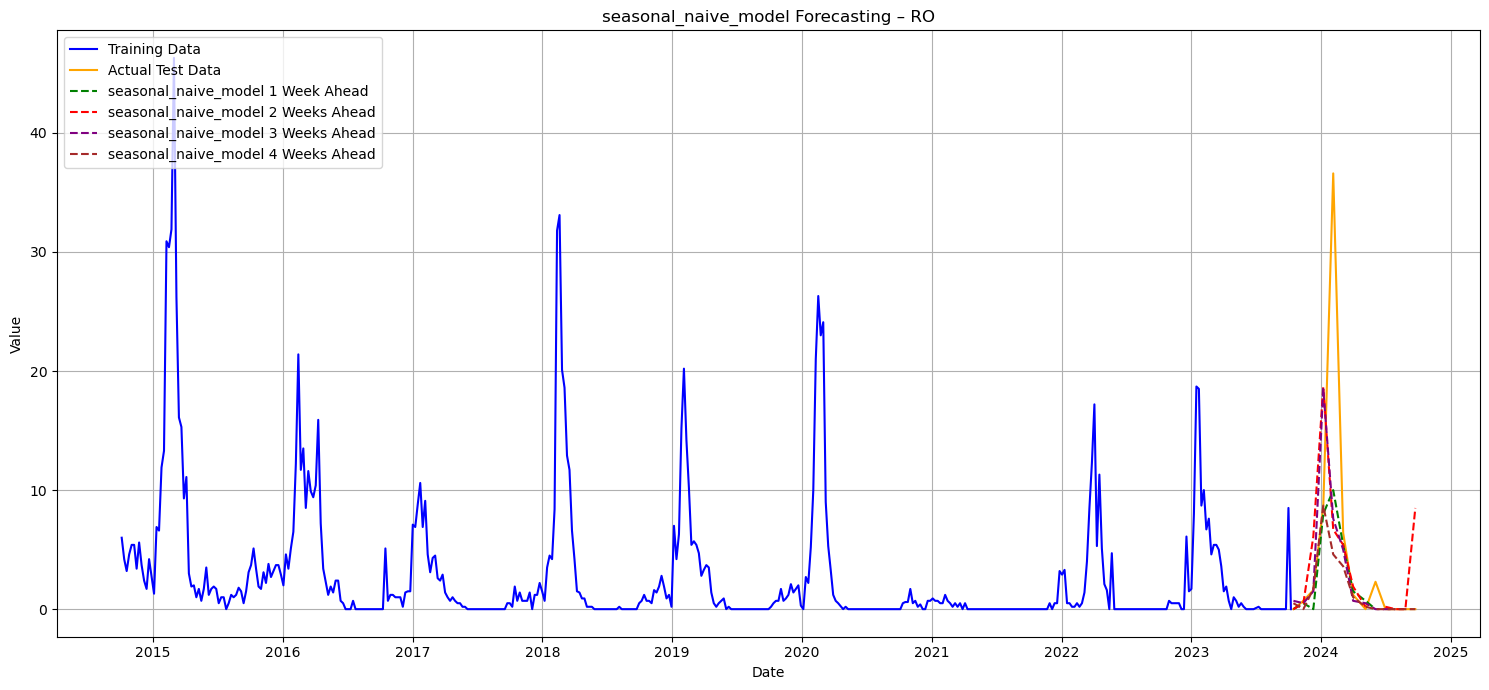

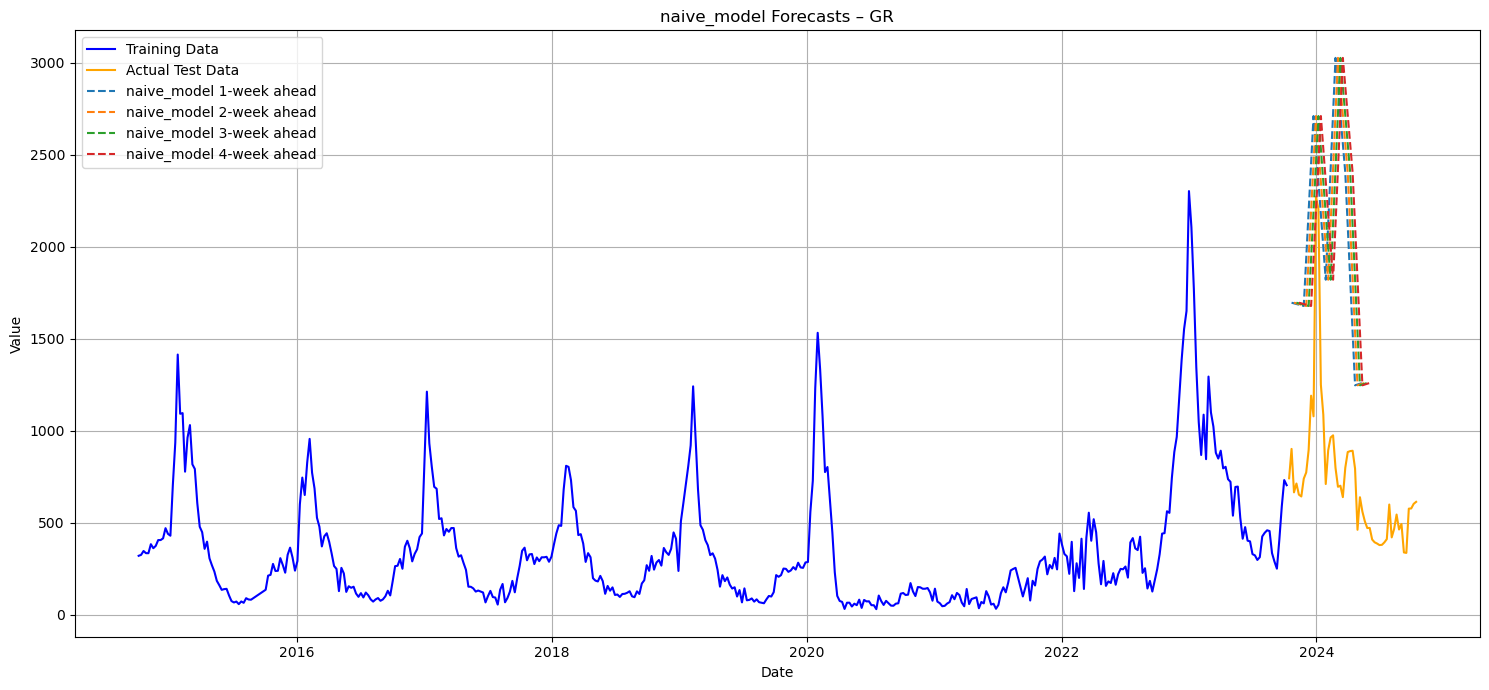

HU


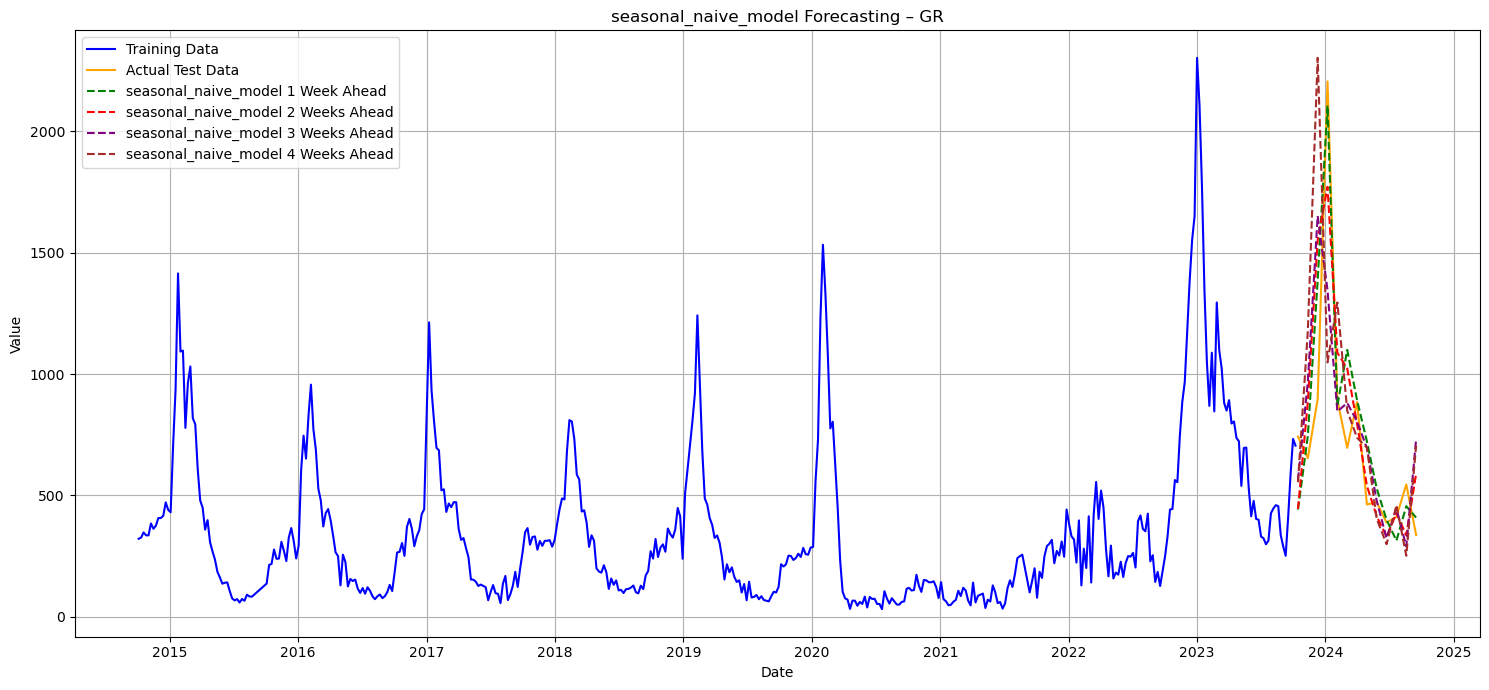

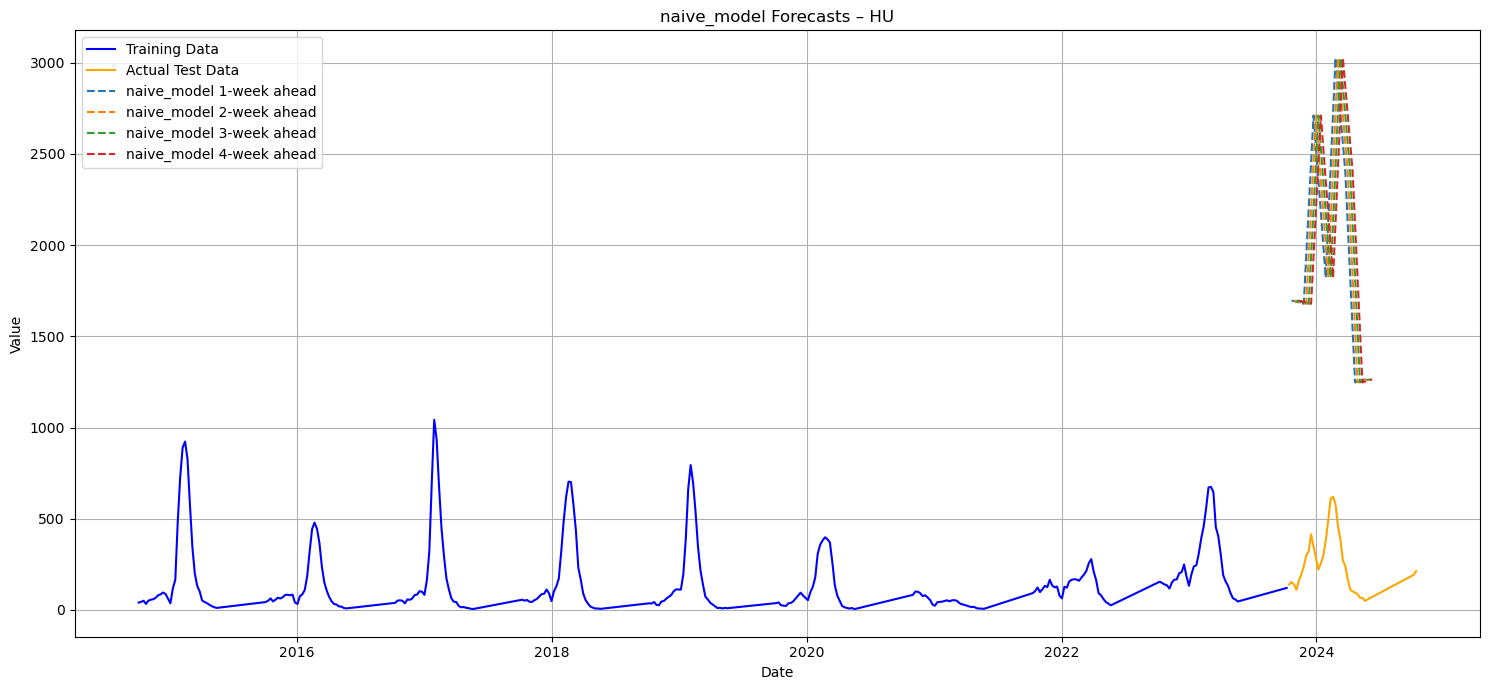

IE


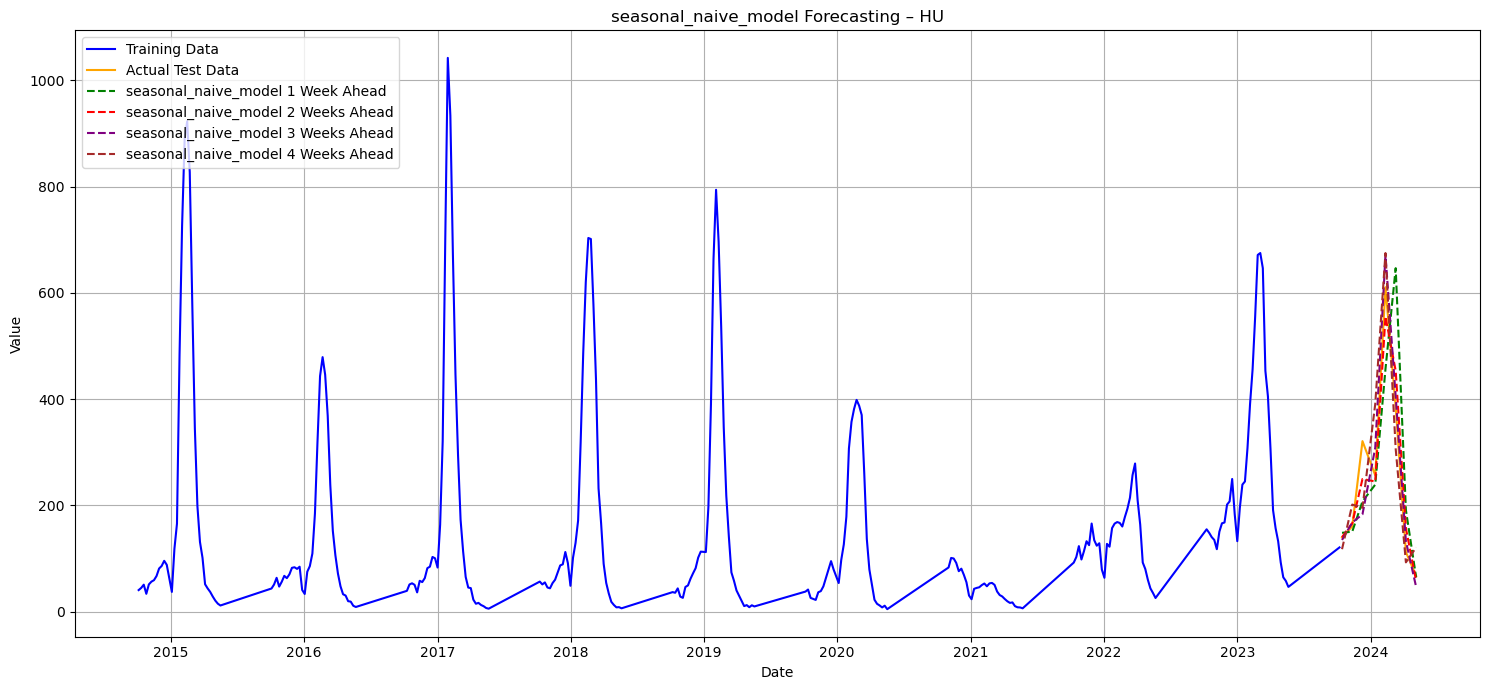

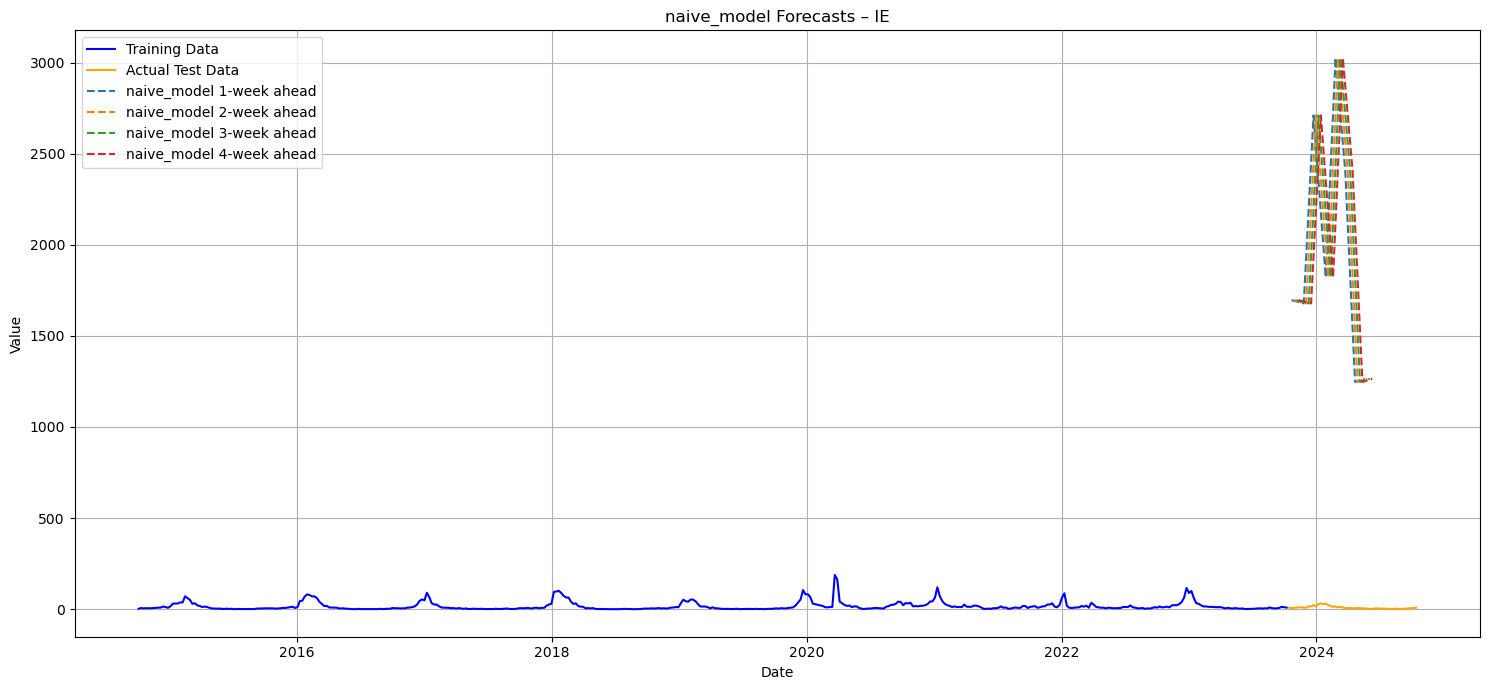

LV


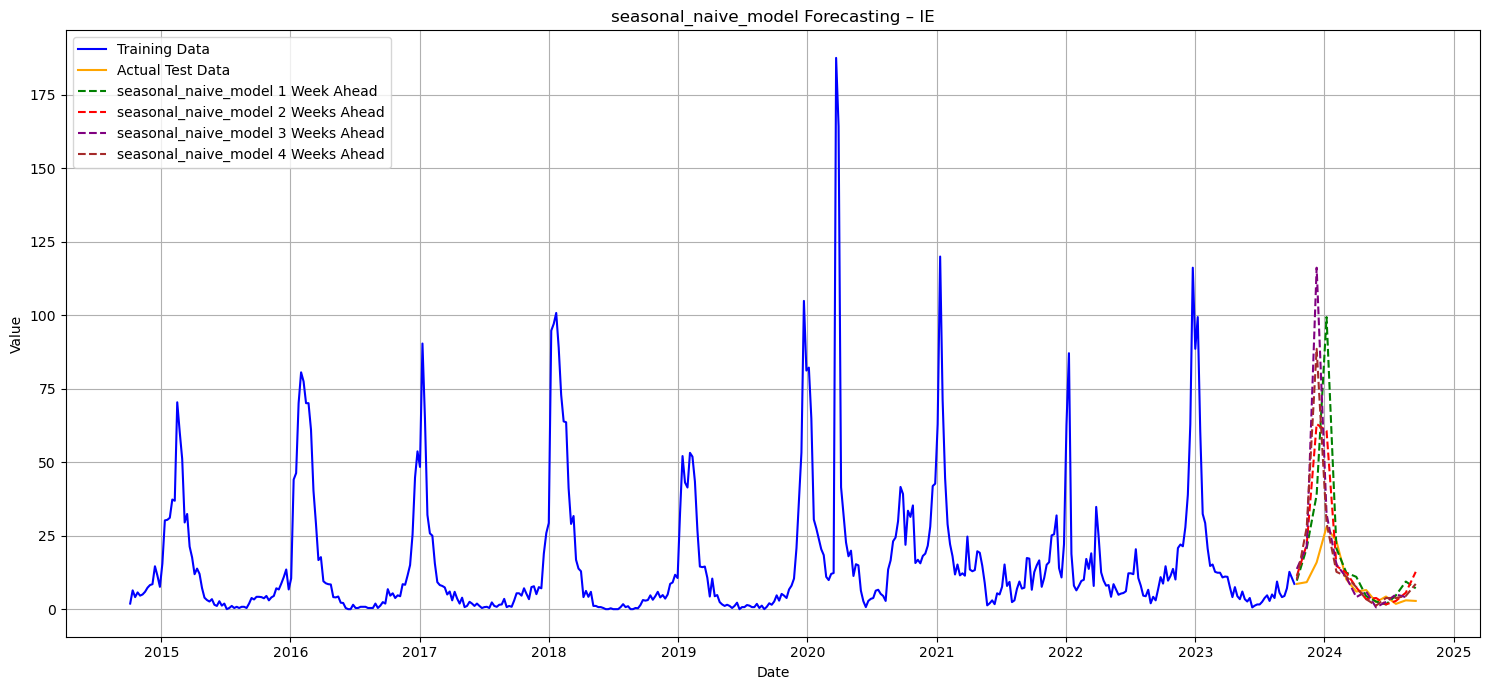

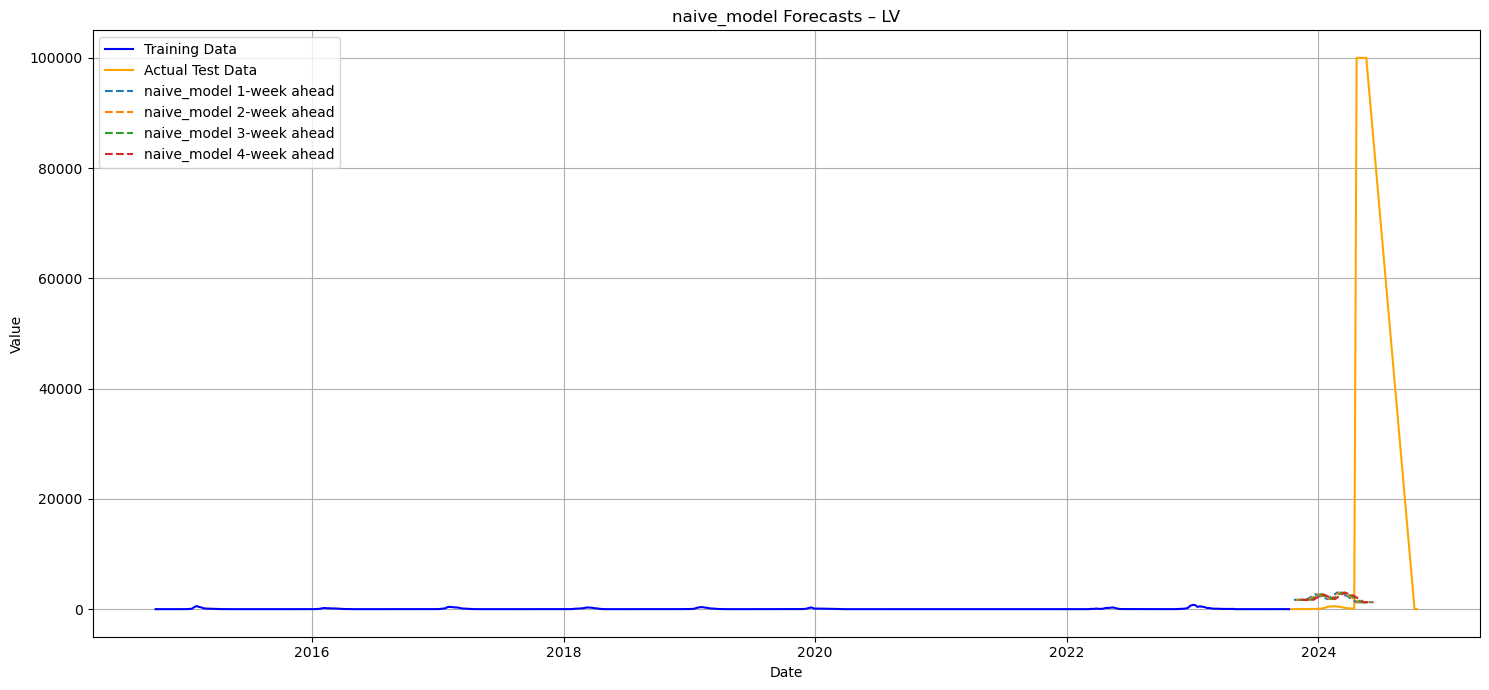

BE


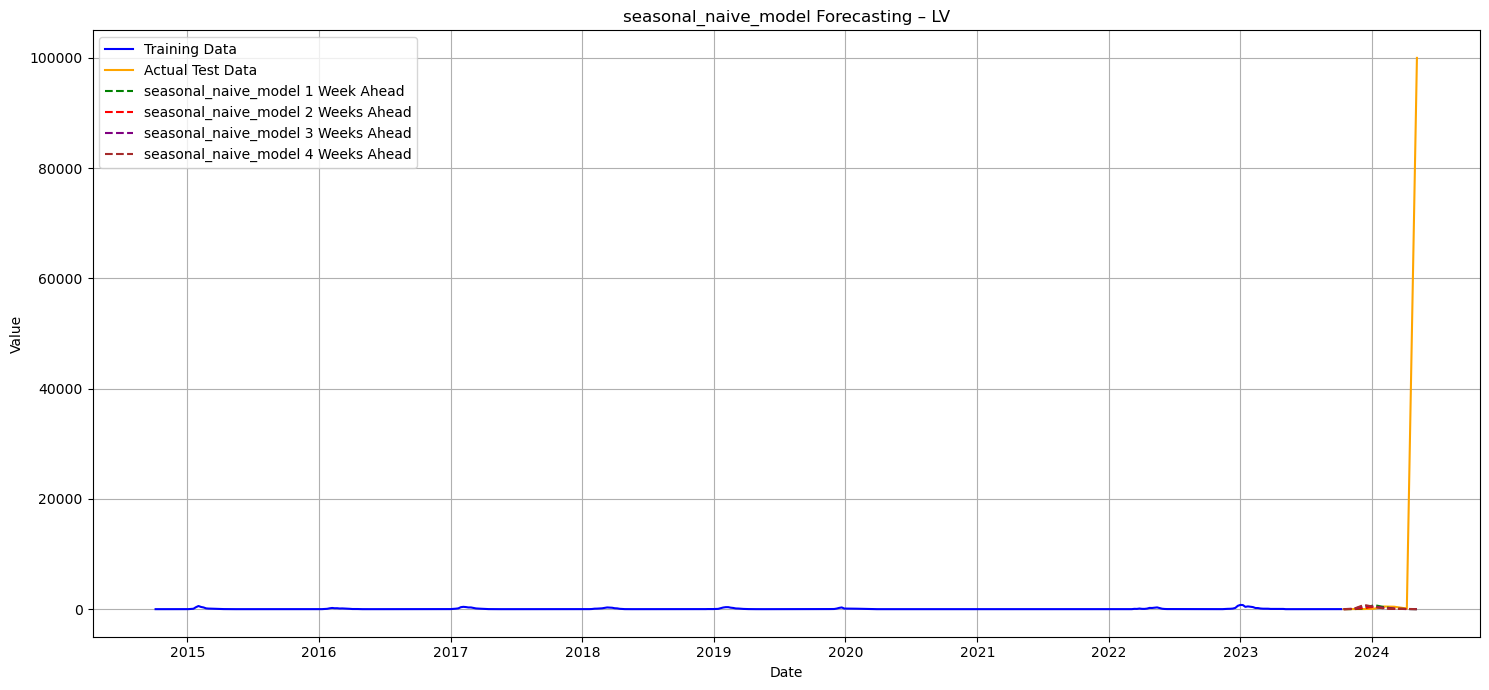

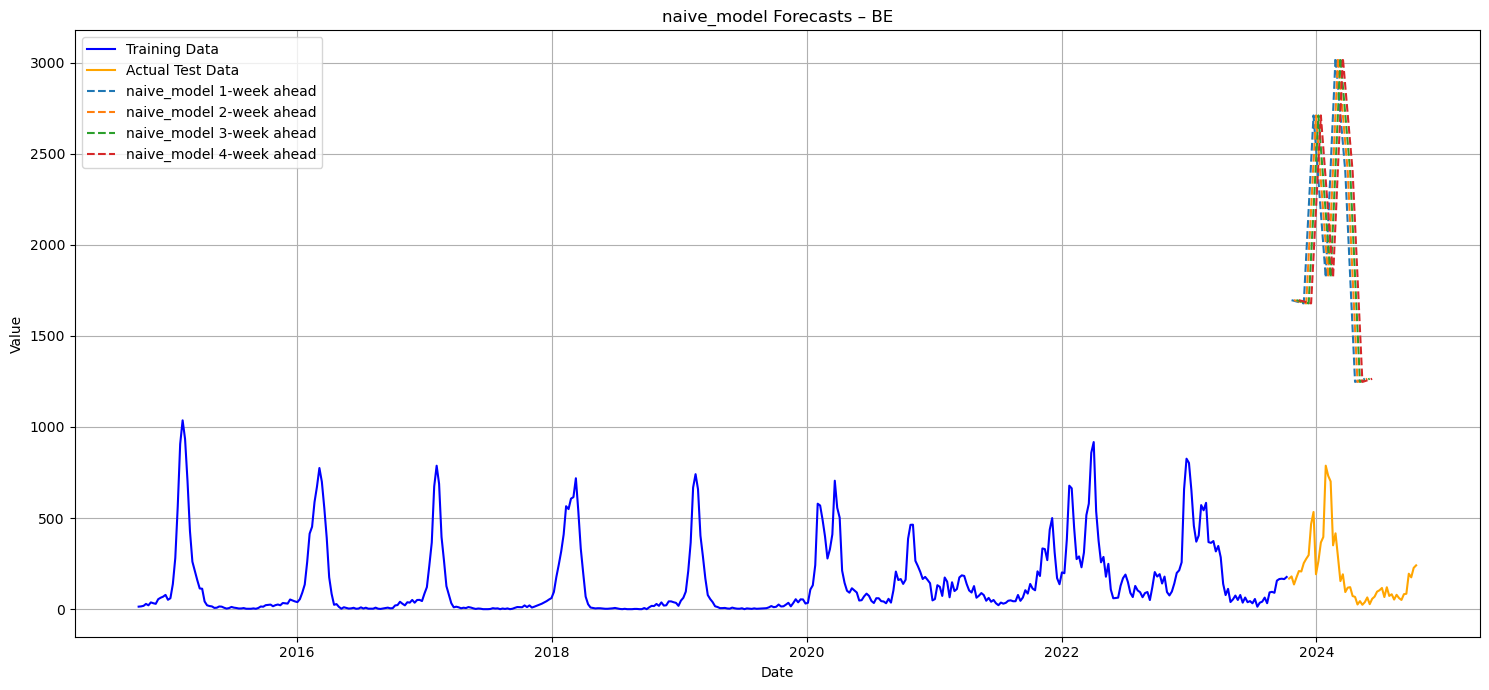

LU


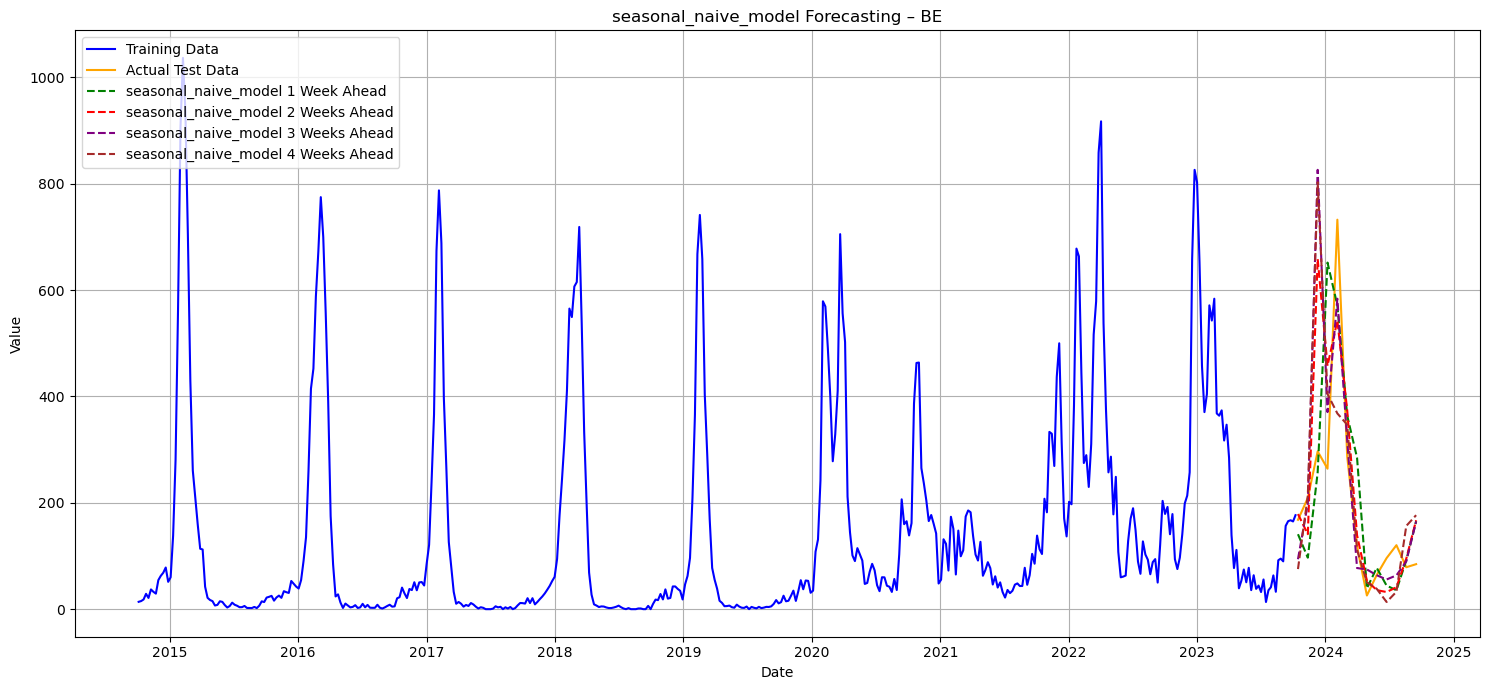

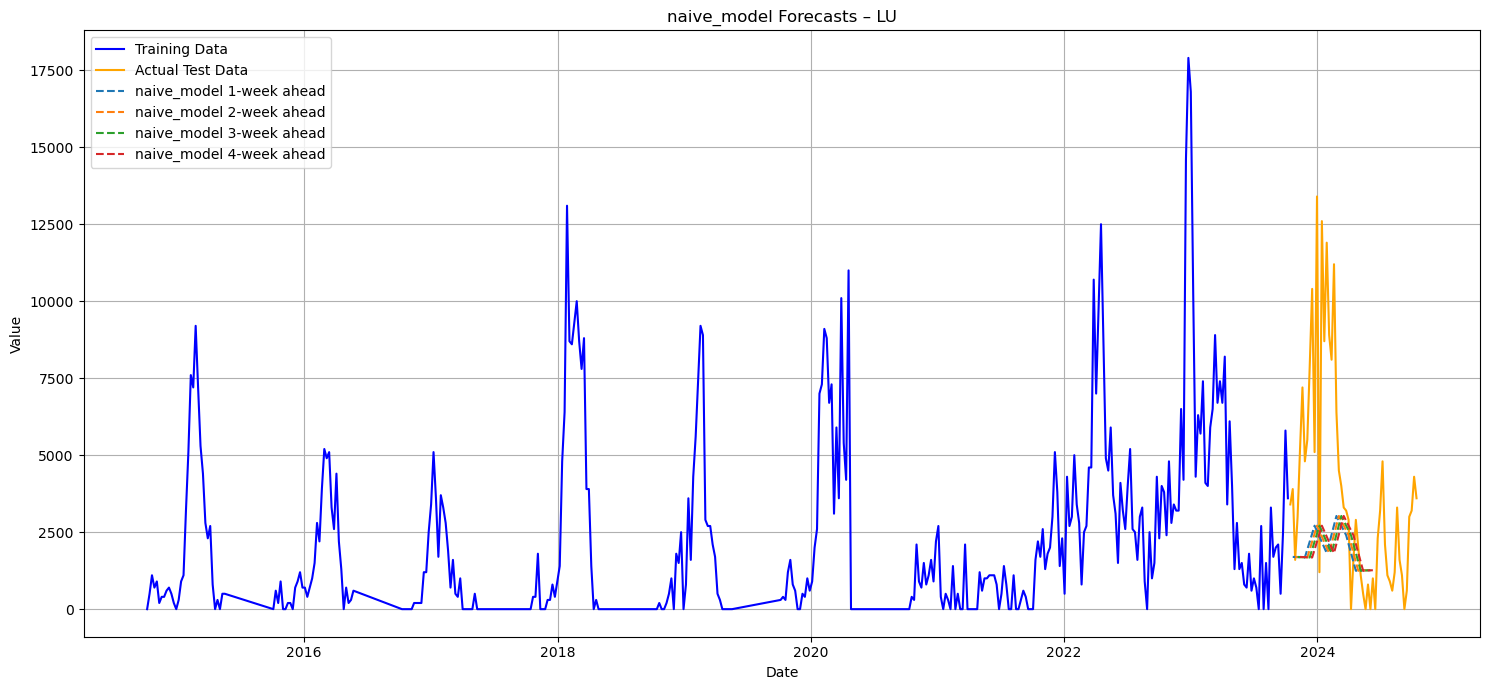

LT


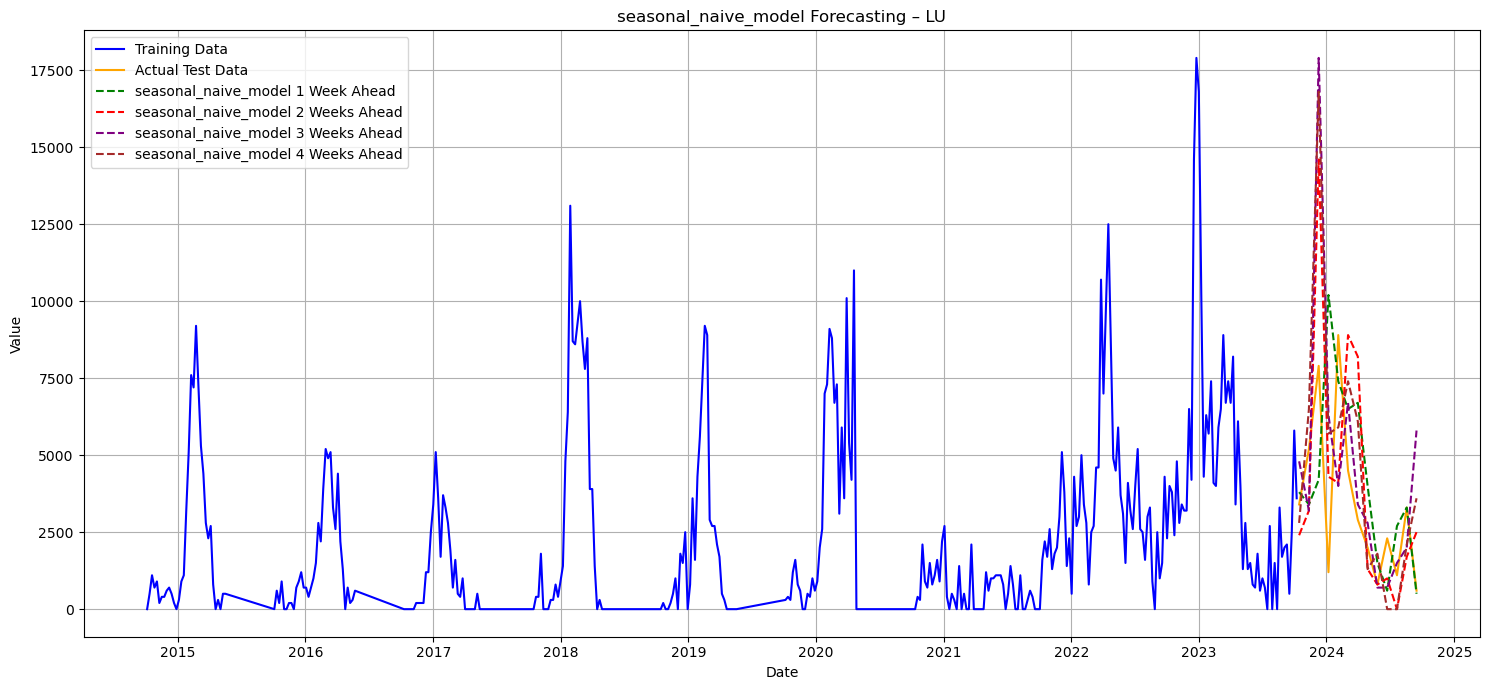

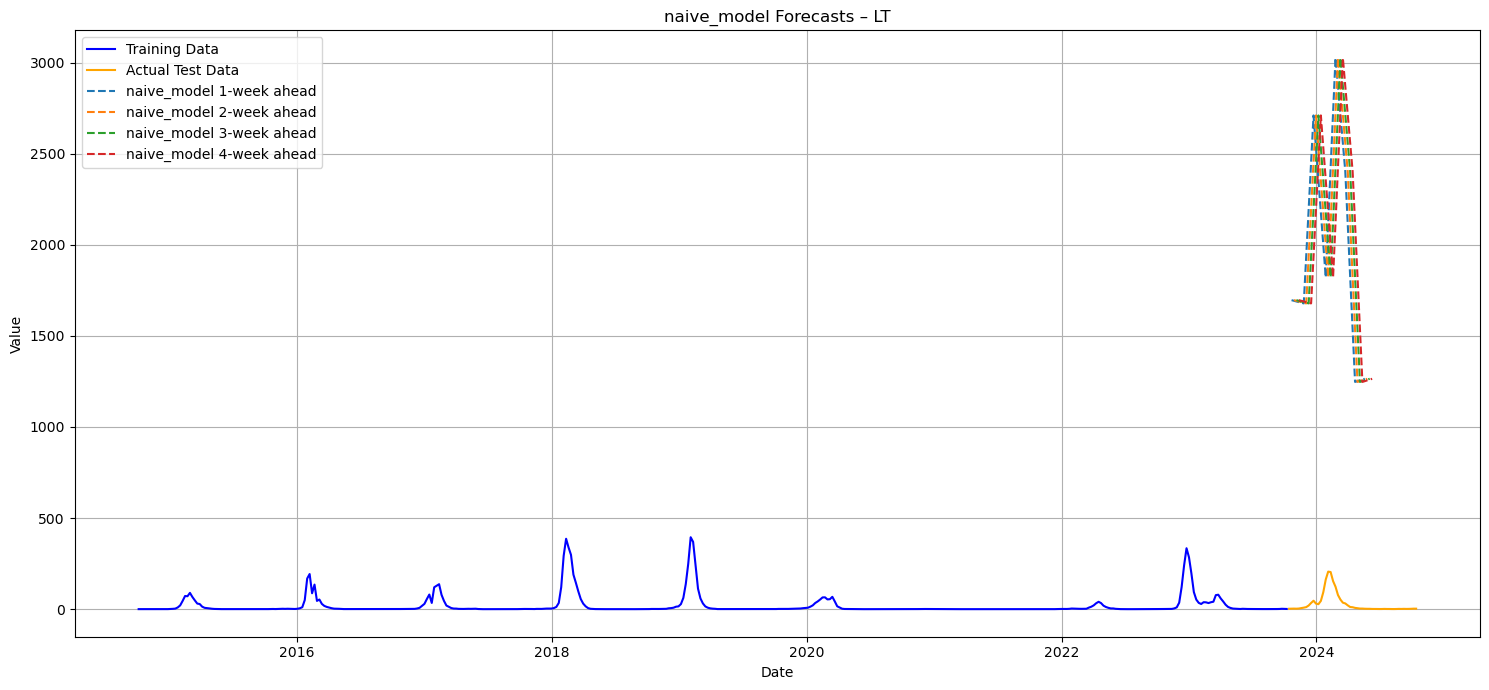

NL


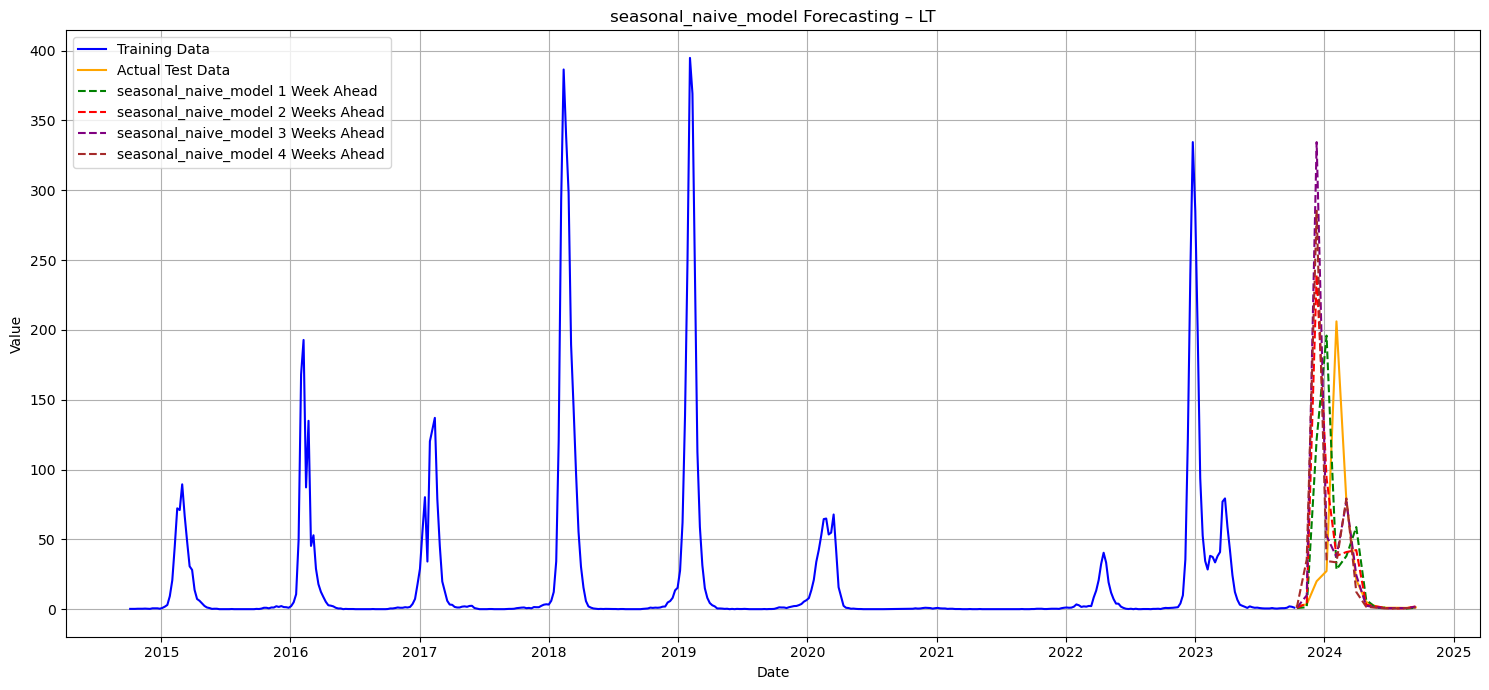

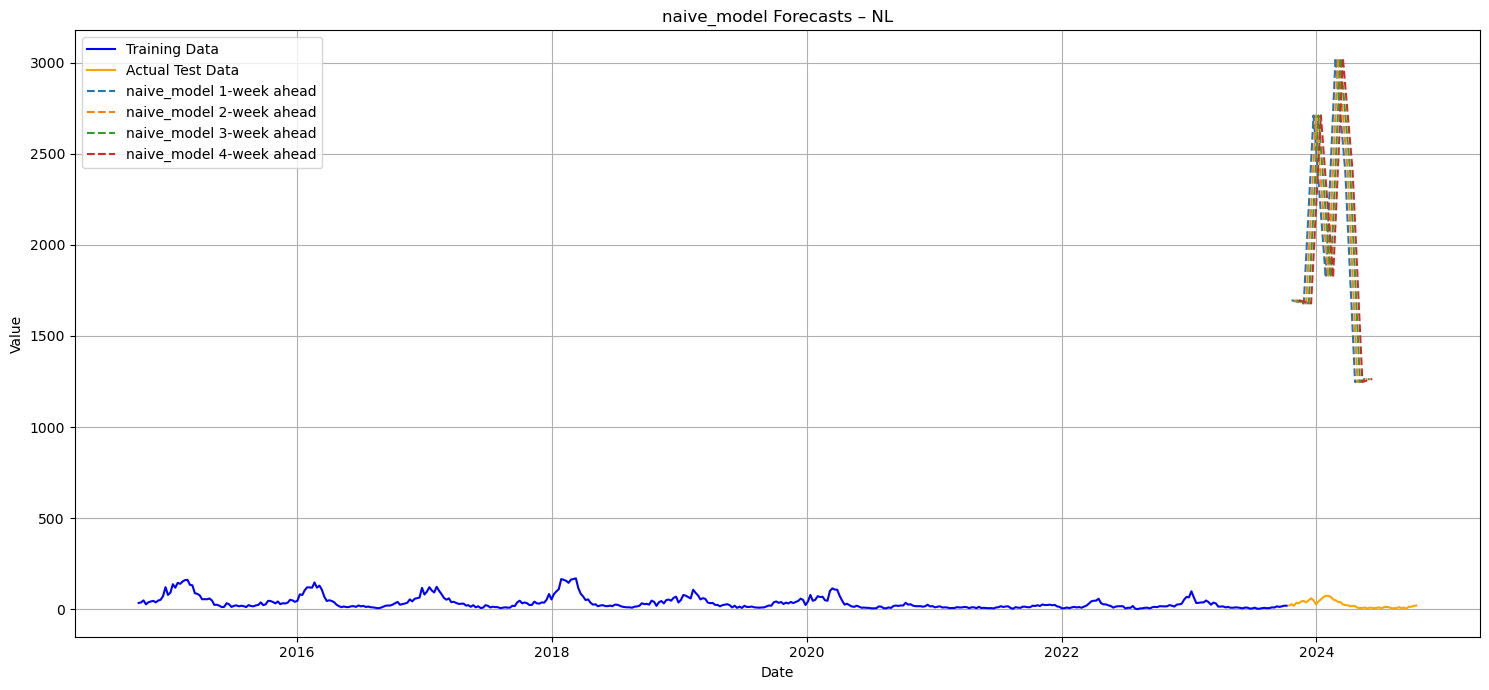

CZ


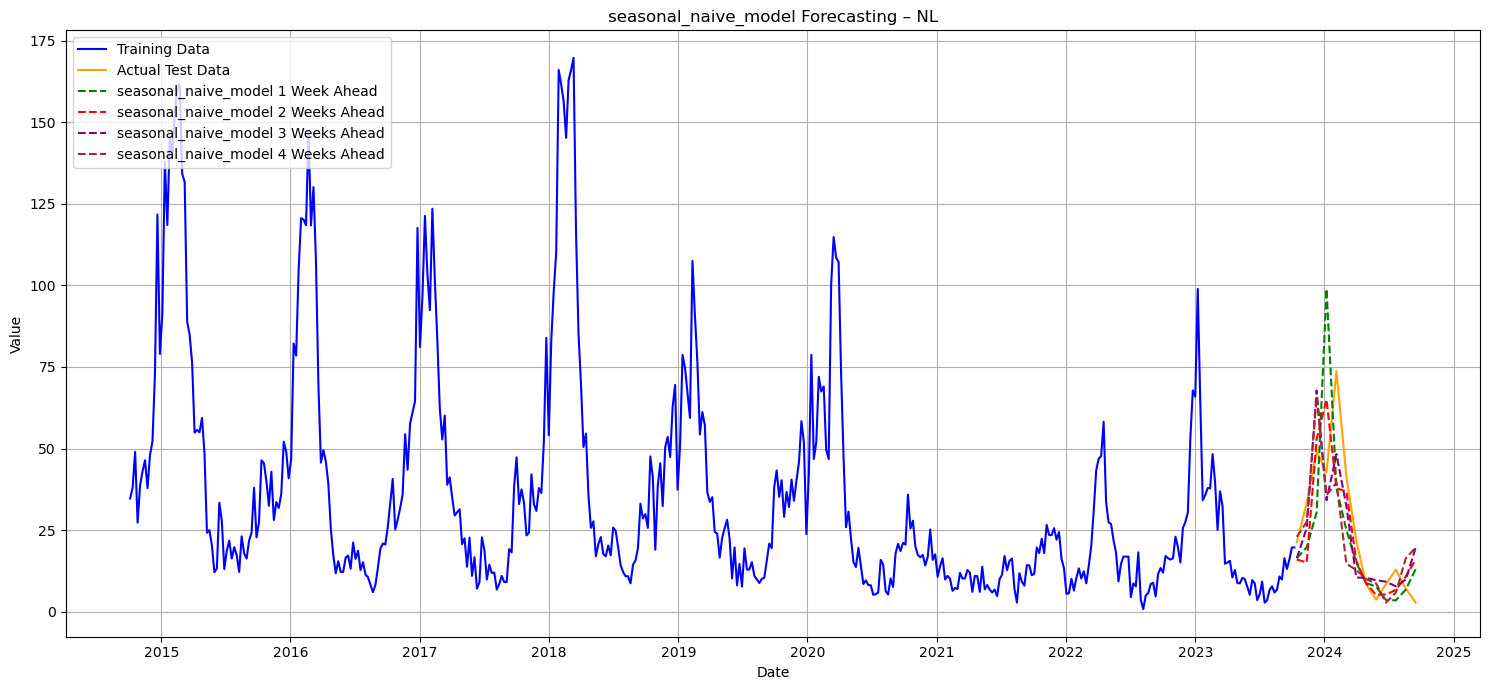

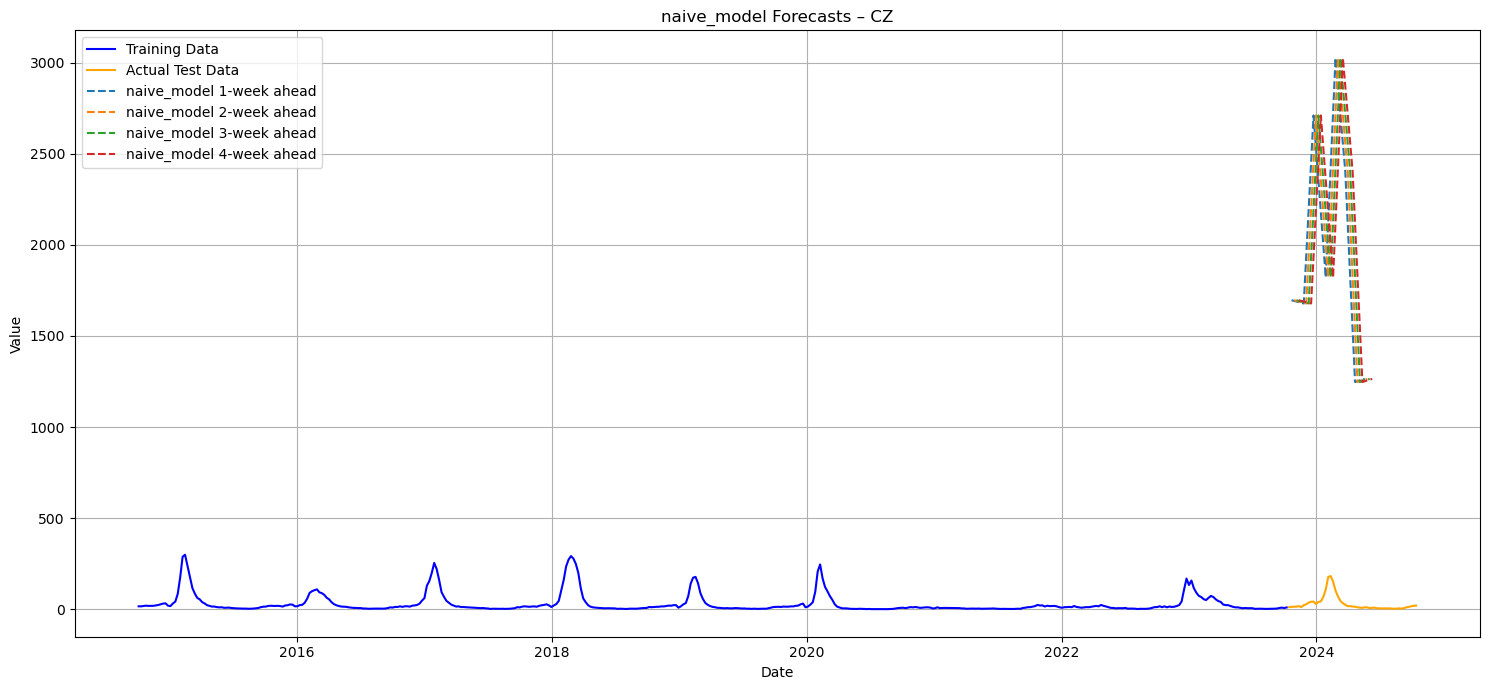

NO


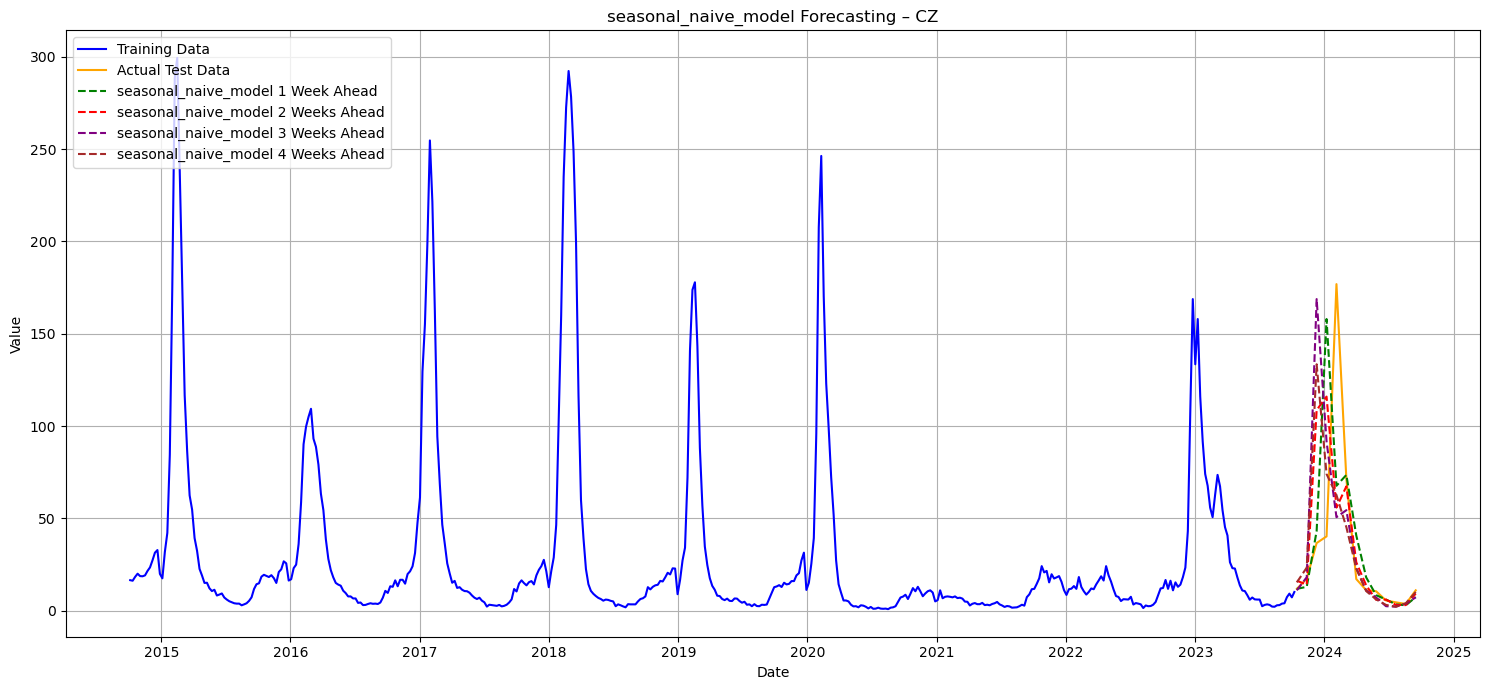

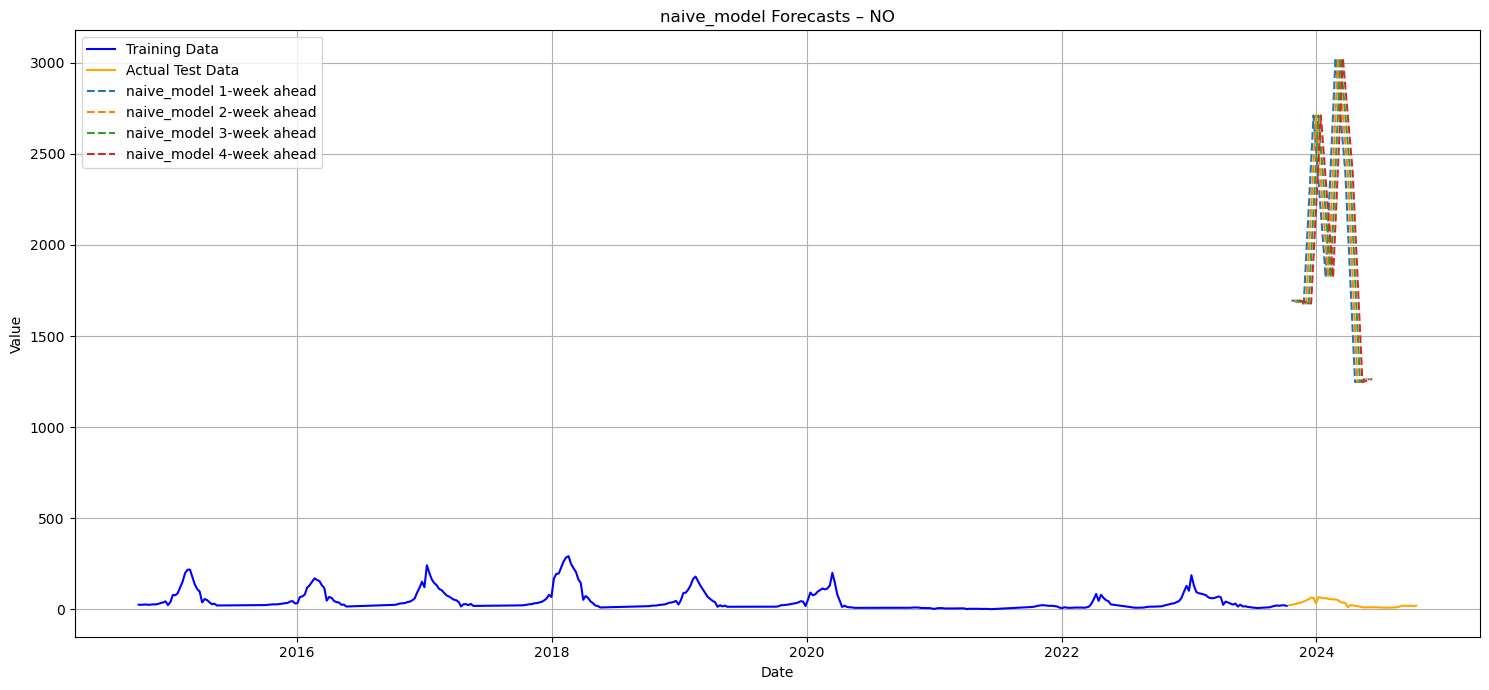

MT


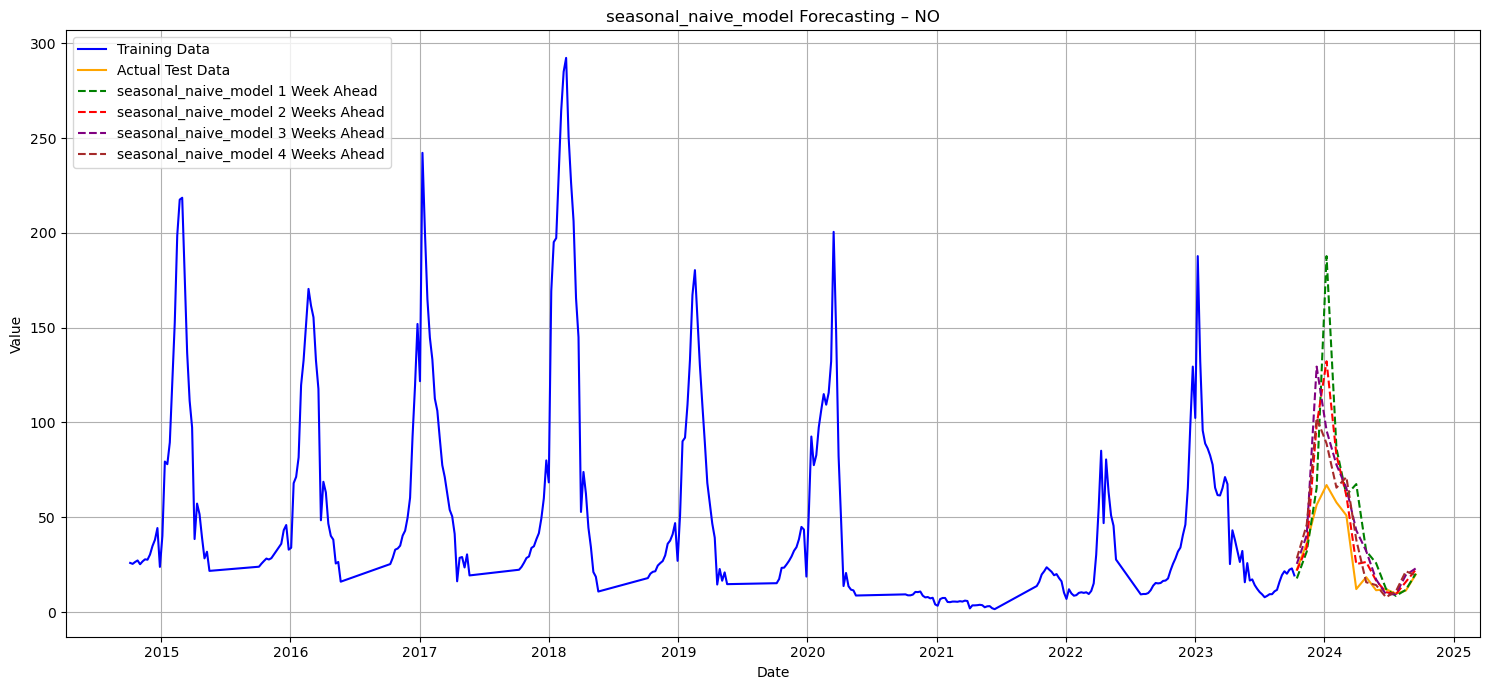

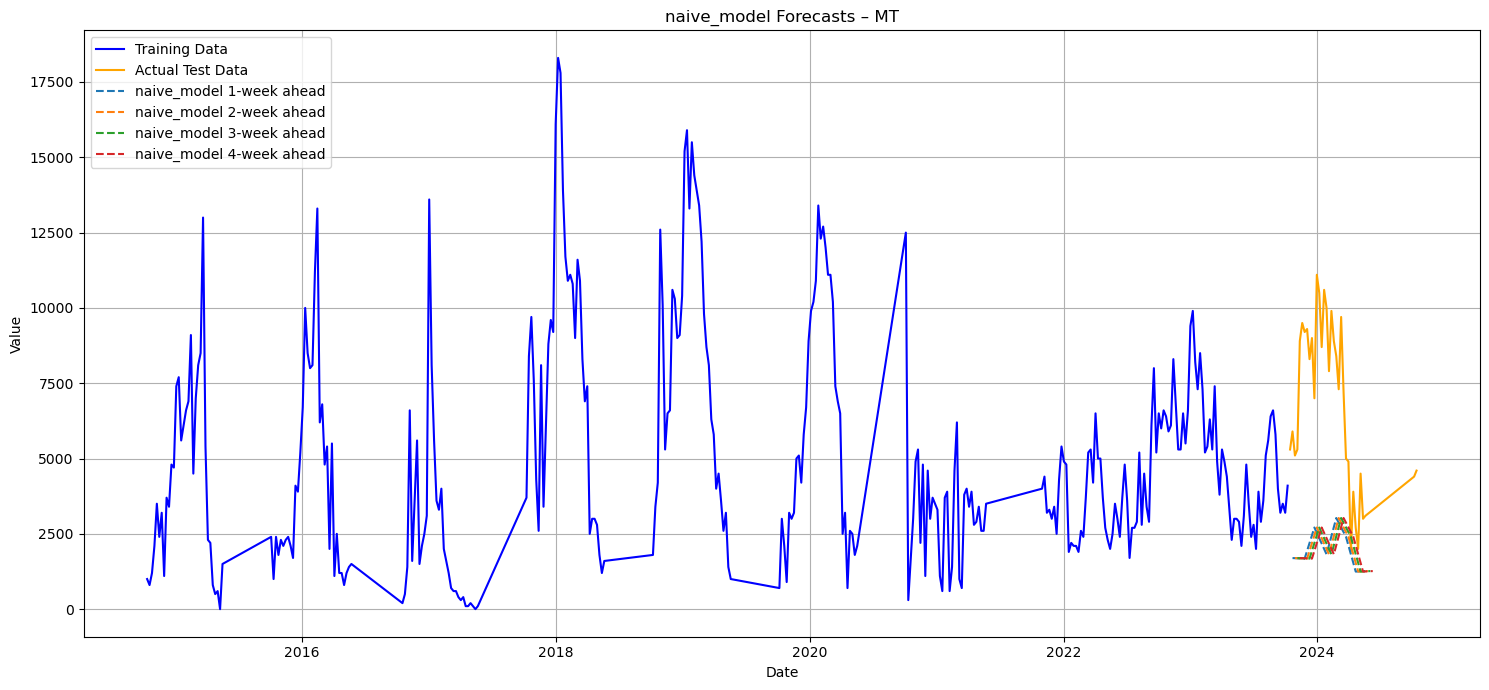

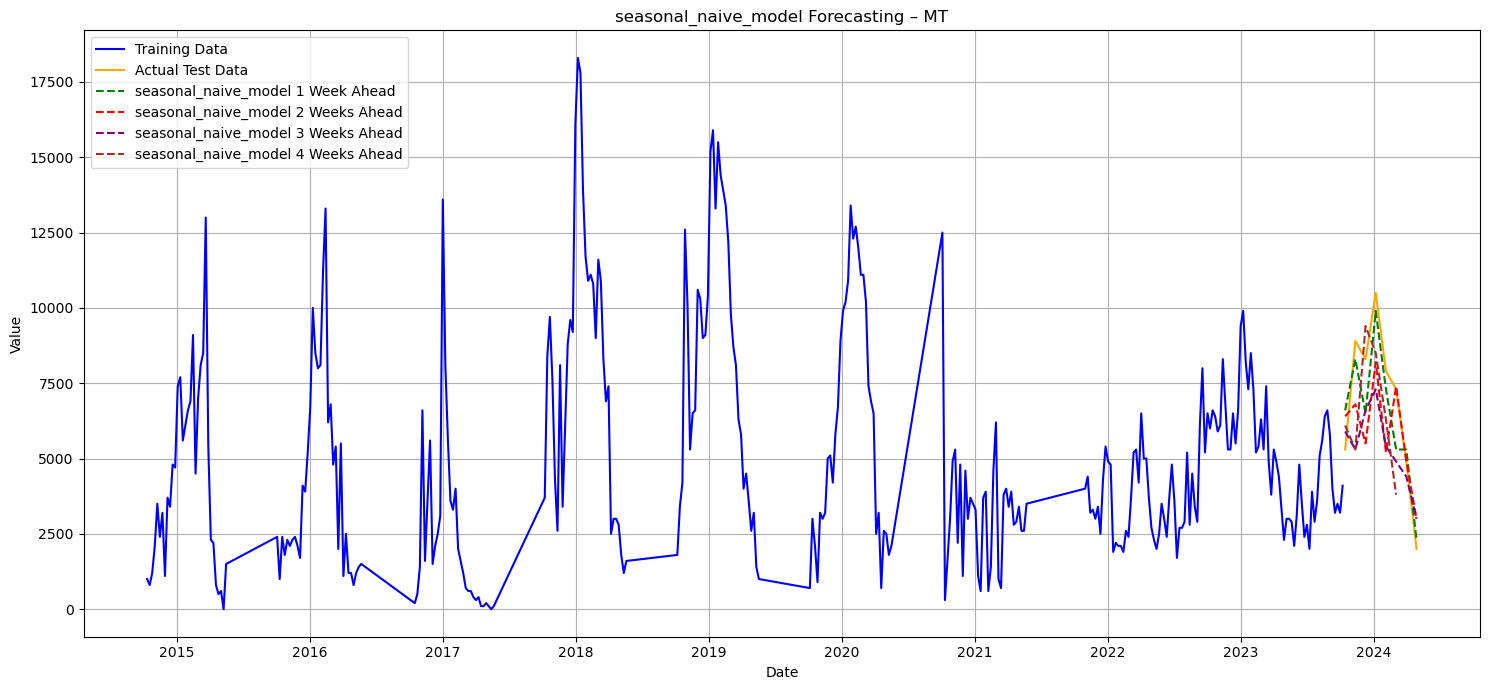

In [174]:
for i in name_ili:
    print(i)
    train_ili,test_ili = train_data(ili,i,'2023-10-13')
    seasonal_test_ili,mape_ili = seasonal_naive_models_1_4_week_rolling(train_ili, test_ili, i, mape_ili, horizon=4, lag=52)
    forecast_df_ili,mape_ari = naive_rolling_4week_multi_forecast(train_ari,test_ari,i,mape_ari)
    plot_multi_horizon_forecasts(train_ili,test_ili,forecast_df_ili,i,'naive_model')
    plot_train_test(train_ili,seasonal_test_ili,'seasonal_naive_model',i,'ili_seasonal_naive')
    

In [175]:
mape_ari.head(30)

location           model prediction_window          mae         rmse
0        CZ  seasonal_naive           1_weeks   153.907700   229.600739
1        CZ  seasonal_naive           2_weeks   150.792297   212.951370
2        CZ  seasonal_naive           3_weeks   151.484604   215.393875
3        CZ  seasonal_naive           4_weeks   142.815399   214.911301
4        CZ           naive            1_week   134.715393   166.272842
5        CZ           naive            2_week   168.461533   213.550934
6        CZ           naive            3_week   252.038437   314.297424
7        CZ           naive            4_week   291.638458   356.594116
8        SI  seasonal_naive           1_weeks   360.476929   457.175568
9        SI  seasonal_naive           2_weeks   301.446136   414.639893
10       SI  seasonal_naive           3_weeks   364.392273   444.300476
11       SI  seasonal_naive           4_weeks   340.015411   515.938416
12       SI           naive            1_week   384.892303   457.869507
13       SI           naive            2_week   468.207672   592.207153
14       SI           naive            3_week   579.015381   712.424377
15       SI           naive            4_week   619.623047   784.004395
16       LU  seasonal_naive           1_weeks  4123.077148  5196.300293
17       LU  seasonal_naive           2_weeks  2592.307617  3061.548096
18       LU  seasonal_naive           3_weeks  5776.922852  7708.686035
19       LU  seasonal_naive           4_weeks  3707.692383  4452.138672
20       LU           naive            1_week  3753.846191  6515.661621
21       LU           naive            2_week  5123.077148  7496.254883
22       LU           naive            3_week  5192.307617  6416.265137
23       LU           naive            4_week  5623.077148  7355.113281
24       EE  seasonal_naive           1_weeks    77.472725    93.124977
25       EE  seasonal_naive           2_weeks    52.700001    64.197868
26       EE  seasonal_naive           3_weeks    43.360004    56.825909
27       EE           naive            1_week    31.472729    41.114540
28       EE           naive            2_week    59.236366    75.082146
29       EE           naive            3_week    84.940002   121.844185

In [176]:
mape_ari.to_csv("mape_ari.csv",index=False)
mape_ili.to_csv("mape_ili.csv",index=False)